# PRUEBA TECNICA CARVAJAL
Andres David Candelo

## Punto 1

### numeral A

In [ ]:
!pip install bayesian-optimization
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.5 MB/s eta 0:00:00


In [ ]:
## Importamos librerias
import csv
import chardet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.sandbox.stats.runs import runstest_1samp
from scipy import stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import het_breuschpagan
#from dataprep.eda import create_report
from scipy.stats import probplot
from statsmodels.stats.stattools import durbin_watson
from dateutil.relativedelta import relativedelta
from pmdarima.arima import auto_arima
from bayes_opt import BayesianOptimization

In [ ]:
# Detecta la codificación del archivo CSV
with open('ventas_train.csv', 'rb') as f:
    result = chardet.detect(f.read())

# Abre el archivo CSV en modo lectura con la codificación detectada
with open('ventas_train.csv', 'r', encoding=result['encoding']) as archivo_csv:
    # Utiliza pandas para crear un DataFrame a partir del archivo CSV
    data = pd.read_csv(archivo_csv)
# Elimina la columna ID de df
data.drop('ID', axis=1, inplace=True)

In [ ]:
data.head()

,ropamujer,correo,páginas,teléfono,impresa,servicio,idmercado,tamañomer,idloc,edadloc,promo,nomina
0,16578.93,7978,73,34,22294.48,20,1,Grande,1,7,3,26780
1,43393.55,8029,65,24,27978.66,26,1,Grande,2,1,2,24789
2,30908.49,7752,85,20,28949.65,22,1,Grande,3,6,2,25121
3,28701.58,8685,74,17,22642.27,21,1,Grande,4,10,1,27648
4,29647.57,7847,87,30,27210.61,23,1,Grande,5,5,3,25982


In [ ]:
data.idloc.value_counts()

1     1
2     1
59    1
58    1
57    1
     ..
26    1
25    1
24    1
23    1
80    1
Name: idloc, Length: 80, dtype: int64

In [ ]:
data.idloc.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80])

#### Modelos Tradicionales

In [ ]:
start_date = '1943-01-01'

# Crea un rango de fechas con las fechas de inicio y fin especificadas, con frecuencia anual ('A')
date_range = pd.date_range(start=start_date, periods=len(data), freq='A')

# Asigna el rango de fechas como el nuevo índice al DataFrame existente
data.index = date_range


In [ ]:
data.head()

,ropamujer,correo,páginas,teléfono,impresa,servicio,idmercado,tamañomer,idloc,edadloc,promo,nomina
1943-12-31,16578.93,7978,73,34,22294.48,20,1,Grande,1,7,3,26780
1944-12-31,43393.55,8029,65,24,27978.66,26,1,Grande,2,1,2,24789
1945-12-31,30908.49,7752,85,20,28949.65,22,1,Grande,3,6,2,25121
1946-12-31,28701.58,8685,74,17,22642.27,21,1,Grande,4,10,1,27648
1947-12-31,29647.57,7847,87,30,27210.61,23,1,Grande,5,5,3,25982


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80 entries, 1943-12-31 to 2022-12-31
Freq: A-DEC
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ropamujer  80 non-null     float64
 1   correo     80 non-null     int64  
 2   páginas    80 non-null     int64  
 3   teléfono   80 non-null     int64  
 4   impresa    80 non-null     float64
 5   servicio   80 non-null     int64  
 6   idmercado  80 non-null     int64  
 7   tamañomer  80 non-null     object 
 8   idloc      80 non-null     int64  
 9   edadloc    80 non-null     int64  
 10  promo      80 non-null     int64  
 11  nomina     80 non-null     int64  
dtypes: float64(2), int64(9), object(1)
memory usage: 8.1+ KB


In [ ]:
df=data.ropamujer

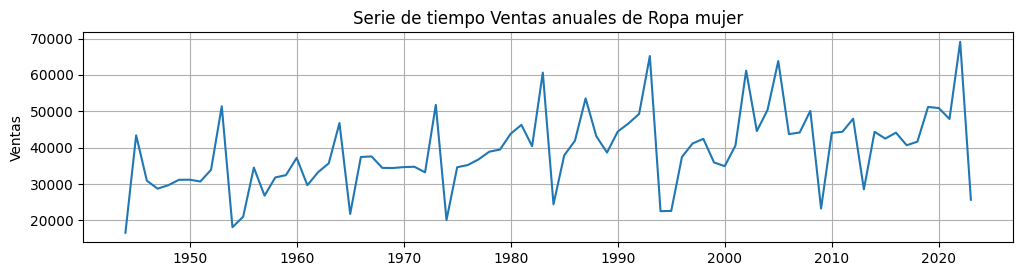

In [ ]:
# Graficando los datos
fig = plt.figure(figsize=(12, 6))

plt.subplot(2,1, 1)
plt.title("Serie de tiempo Ventas anuales de Ropa mujer")
plt.ylabel("Ventas")
plt.plot(data["ropamujer"])
plt.grid()

plt.show()

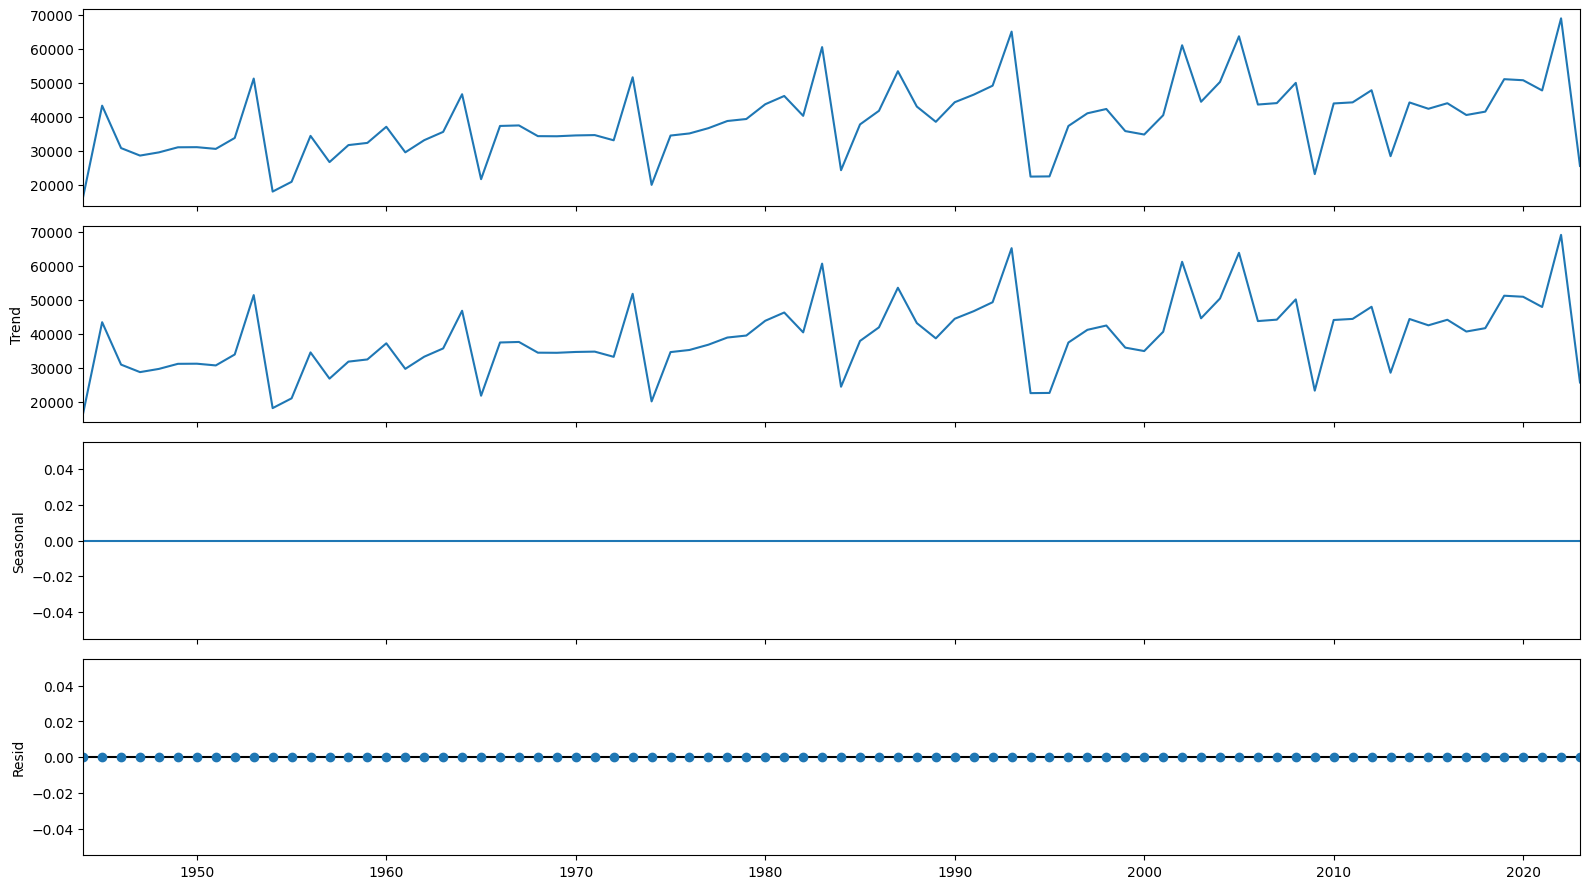

In [ ]:
componentes = seasonal_decompose(data[["ropamujer"]],model="additive")
fig = componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

## Autocorrelacion
Autocorrelación
Para determinar si existe autocorrelación vamos a usar la prueba de rachas propuesta por Wald y Wolfowitz, 1940. Es una prueba no paramétrica donde las hipótesis son las siguientes:

𝐻0:ρ=0
  (Es decir no hay autocorrelación)

𝐻1:ρ≠0
  (Es decir hay autocorrelación)

Rechazo  𝐻0
  cuando el p-valor es menor al nivel de significancia, convencionalmente se usa un  α
 =0.05 ( α
  = nivel de significancia).

In [ ]:
signo = data.ropamujer
runstest_1samp(signo, correction=False)

(-4.038362757624545, 5.382557014567842e-05)

Los resultados permiten rechazar la no autocorrelación (p-value=0) y por lo tanto se puede concluir que existe autocorrelación en la serie, es decir, con esta prueba la serie de ventas ropa mujer no parece comportarse como ruido blanco.

In [ ]:
Resul_lb_bp = sm.stats.acorr_ljungbox(data.ropamujer, lags=range(1,21), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,1.318004,0.250951,1.269784,0.259807,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
2,3.700931,0.157164,3.536471,0.170634,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
3,7.512221,0.057245,7.115365,0.068310,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
4,10.407178,0.034100,9.798496,0.043962,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
5,12.729131,0.026054,11.922234,0.035869,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
6,15.615103,0.015976,14.526647,0.024276,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
7,15.898209,0.026063,14.778681,0.038943,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
8,16.086349,0.041161,14.943877,0.060246,rechazo_ho/hay_autocorr,no_rechazo_ho/no_hay_autocorr
9,16.268894,0.061474,15.101934,0.088174,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
10,25.421878,0.004601,22.915457,0.011063,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr


In [ ]:
data.shape

(80, 12)

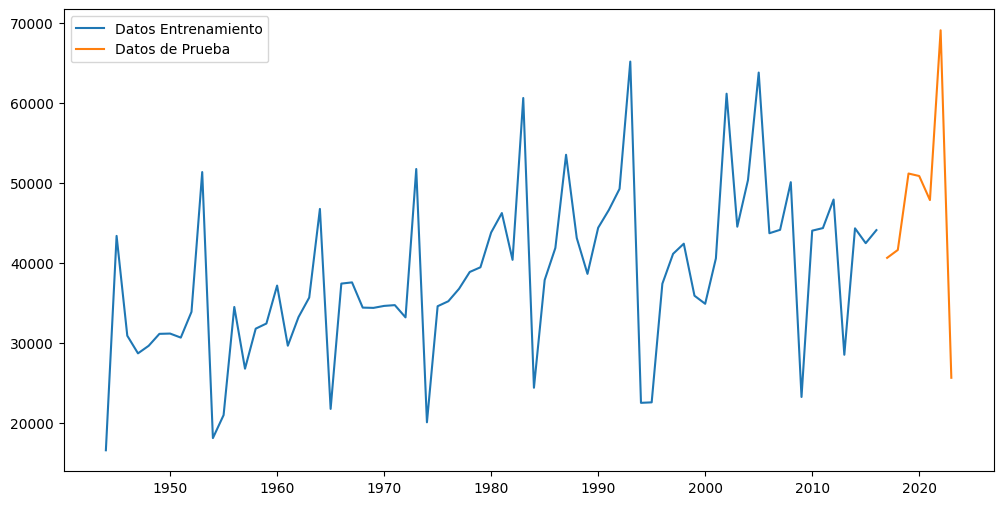

In [ ]:
train_len = 80-7
train_p1 = data[["ropamujer"]][:train_len]
test_p1 = data[["ropamujer"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_p1,label="Datos Entrenamiento")
plt.plot(test_p1,label="Datos de Prueba")
plt.legend()
plt.show()

In [ ]:
y = train_p1["ropamujer"]
x = np.linspace(1,train_p1.shape[0],train_p1.shape[0])
X = sm.add_constant(x)
lin = sm.OLS(y,X)
lin_t = lin.fit()
print(lin_t.summary())

                            OLS Regression Results                            
Dep. Variable:              ropamujer   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     18.71
Date:                Sat, 13 Jan 2024   Prob (F-statistic):           4.88e-05
Time:                        22:33:34   Log-Likelihood:                -769.68
No. Observations:                  73   AIC:                             1543.
Df Residuals:                      71   BIC:                             1548.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.995e+04   2201.076     13.606      0.0

In [ ]:
h=7
x_for= np.linspace((train_p1.shape[0]+1),(train_p1.shape[0]+h),h)
X_for= sm.add_constant(x_for)
dt = lin_t.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

   Point_forecast      lower_95      upper_95
0    46494.741370  27426.063317  65563.419423
1    46718.361988  27628.802004  65807.921973
2    46941.982606  27831.007577  66052.957636
3    47165.603225  28032.681826  66298.524623
4    47389.223843  28233.826578  66544.621108
5    47612.844461  28434.443695  66791.245228
6    47836.465080  28634.535071  67038.395088


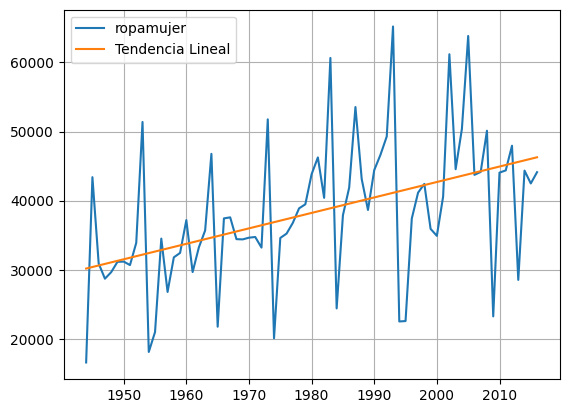

In [ ]:
plt.plot(y,label="ropamujer")
plt.plot(lin_t.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

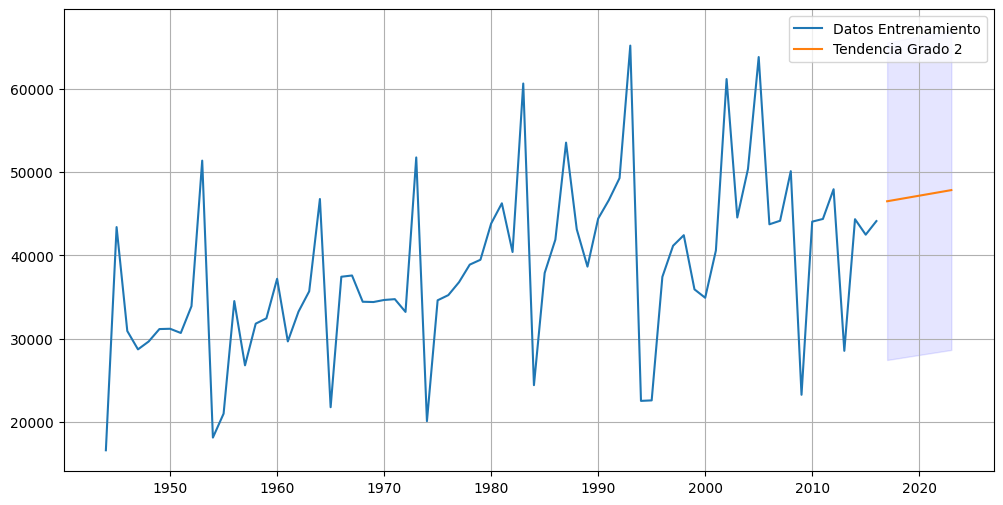

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_p1.index,train_p1.ropamujer,label="Datos Entrenamiento")
plt.plot(test_p1.index,preds['Point_forecast'],label="Tendencia Grado 2")
plt.fill_between(test_p1.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Calcular el ECM
ecm_tendencial_lineal = mean_squared_error(test_p1['ropamujer'], preds['Point_forecast'])

# Imprimir el resultado
print(f"Error Cuadrático Medio (ECM): {ecm_tendencial_lineal}")


Error Cuadrático Medio (ECM): 149535494.63808957


### Polinomica Grado 2

In [ ]:
train_len = 80-7
train_p1 = data[["ropamujer"]][:train_len]
test_p1 = data[["ropamujer"]][train_len:]

In [ ]:
y = train_p1["ropamujer"]
z = np.linspace(1,train_p1.shape[0],train_p1.shape[0])
train_p1["z"] = z
train_p1["z2"] = z**2
X = sm.add_constant(train_p1[["z","z2"]])
pol = sm.OLS(y,X)
pol_2 = pol.fit()
print(pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:              ropamujer   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     9.984
Date:                Sat, 13 Jan 2024   Prob (F-statistic):           0.000153
Time:                        22:33:35   Log-Likelihood:                -769.06
No. Observations:                  73   AIC:                             1544.
Df Residuals:                      70   BIC:                             1551.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.717e+04   3354.592      8.099      0.0

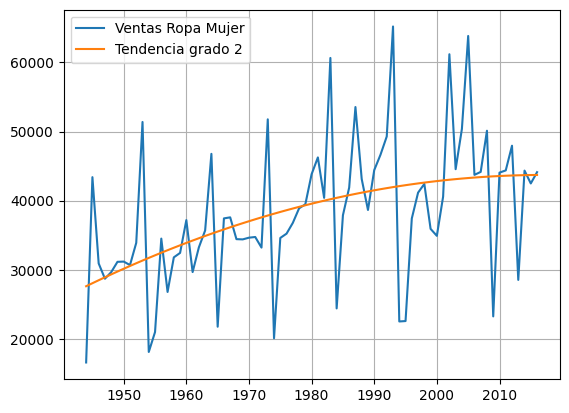

In [ ]:
plt.plot(y,label="Ventas Ropa Mujer")
plt.plot(pol_2.fittedvalues,label="Tendencia grado 2")
plt.legend()
plt.grid()
plt.show()

In [ ]:
h=7
x_for= np.linspace((train_p1.shape[0]+1),(train_p1.shape[0]+h),h)
X_for= sm.add_constant(np.stack((x_for, x_for**2), axis=1))

In [ ]:
dt = pol_2.get_prediction(X_for).summary_frame(alpha=0.05)
y_prd = dt["mean"]
yprd_ci_lower = dt["obs_ci_lower"]
yprd_ci_upper = dt["obs_ci_upper"]
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ["Point_forecast", "lower_95", "upper_95"]
print(preds)

   Point_forecast      lower_95      upper_95
0    43716.022566  24010.496706  63421.548427
1    43714.341660  23879.691933  63548.991387
2    43706.652713  23731.555528  63681.749898
3    43692.955725  23565.639193  63820.272258
4    43673.250697  23381.510405  63964.990990
5    43647.537628  23178.754355  64116.320902
6    43615.816519  22956.975739  64274.657298


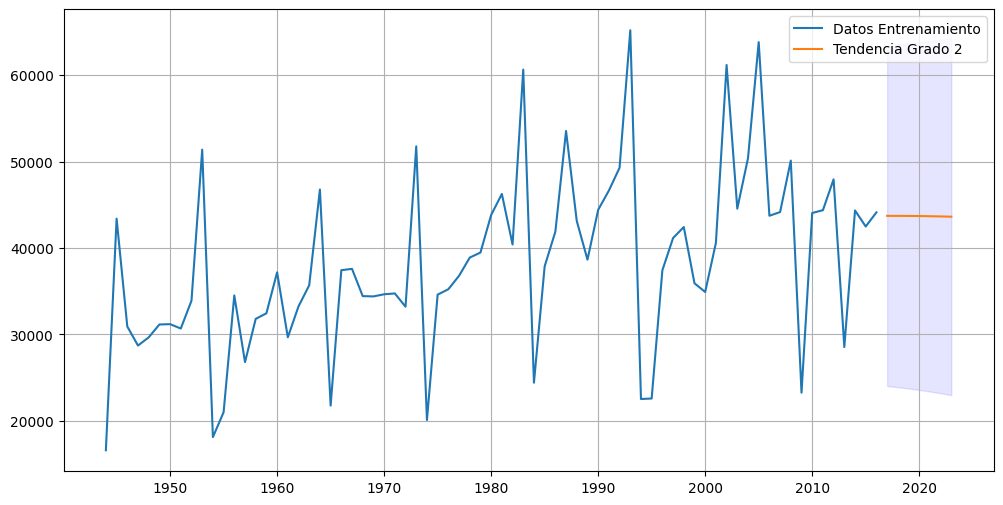

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_p1.index,train_p1.ropamujer,label="Datos Entrenamiento")
plt.plot(test_p1.index,preds['Point_forecast'],label="Tendencia Grado 2")
plt.fill_between(test_p1.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Calcular el ECM
ecm_grado2 = mean_squared_error(test_p1['ropamujer'], preds['Point_forecast'])

# Imprimir el resultado
print(f"Error Cuadrático Medio (ECM): {ecm_grado2}")

Error Cuadrático Medio (ECM): 158645374.16082832


### POLINOMIO GRADO 3

In [ ]:
train_len = 80-7
train_p1 = data[["ropamujer"]][:train_len]
test_p1 = data[["ropamujer"]][train_len:]

In [ ]:
y = train_p1["ropamujer"]
z = np.linspace(1,train_p1.shape[0],train_p1.shape[0])
train_p1["z"] = z
train_p1["z2"] = z**2
train_p1["z3"] = z**3
X = sm.add_constant(train_p1[["z","z2", "z3"]])
pol = sm.OLS(y,X)
pol_3 = pol.fit()
print(pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:              ropamujer   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     6.944
Date:                Sat, 13 Jan 2024   Prob (F-statistic):           0.000376
Time:                        22:33:35   Log-Likelihood:                -768.59
No. Observations:                  73   AIC:                             1545.
Df Residuals:                      69   BIC:                             1554.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.012e+04   4587.730      6.566      0.0

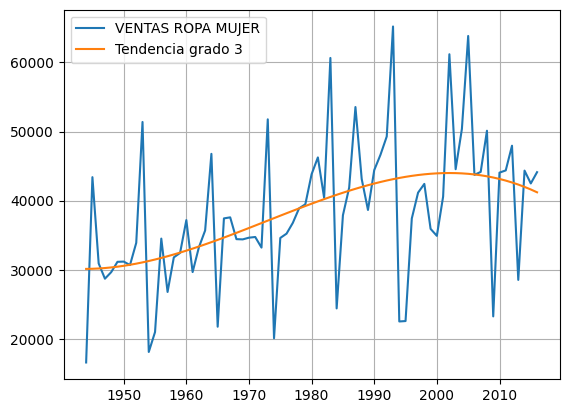

In [ ]:
plt.plot(y,label="VENTAS ROPA MUJER")
plt.plot(pol_3.fittedvalues,label="Tendencia grado 3")
plt.legend()
plt.grid()
plt.show()

In [ ]:
h=7
x_for= np.linspace((train_p1.shape[0]+1),(train_p1.shape[0]+h),h)
X_for= sm.add_constant(np.stack((x_for, x_for**2, x_for**3), axis=1))

In [ ]:
dt = pol_3.get_prediction(X_for).summary_frame(alpha=0.05)
y_prd = dt["mean"]
yprd_ci_lower = dt["obs_ci_lower"]
yprd_ci_upper = dt["obs_ci_upper"]
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ["Point_forecast", "lower_95", "upper_95"]
print(preds)

   Point_forecast      lower_95      upper_95
0    40760.578188  20072.223052  61448.933323
1    40279.636031  19142.781766  61416.490295
2    39760.735083  18100.244635  61421.225531
3    39203.034536  16937.891571  61468.177501
4    38605.693579  15649.453587  61561.933571
5    37967.871404  14229.193889  61706.548919
6    37288.727202  12671.957627  61905.496776


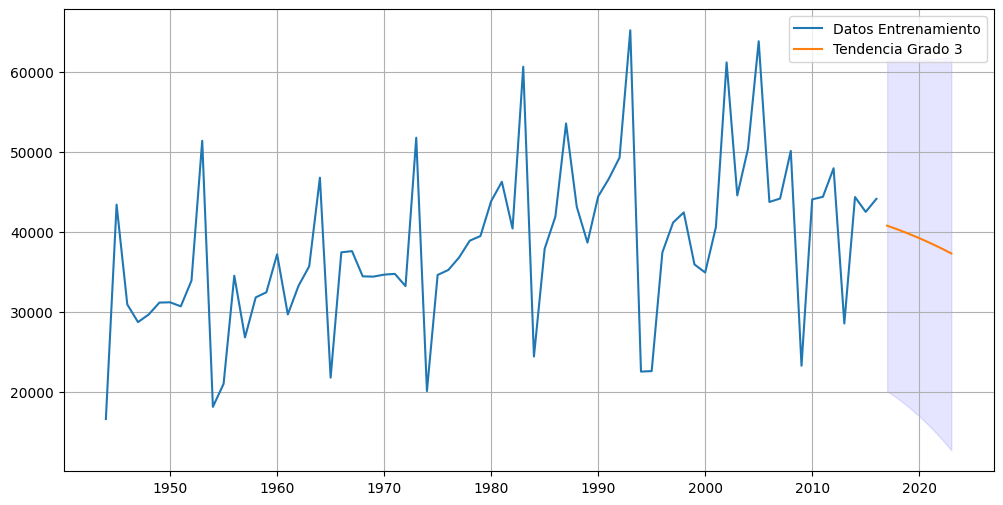

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_p1.index,train_p1.ropamujer,label="Datos Entrenamiento")
plt.plot(test_p1.index,preds['Point_forecast'],label="Tendencia Grado 3")
plt.fill_between(test_p1.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Calcular el ECM
ecm_grado3 = mean_squared_error(test_p1['ropamujer'], preds['Point_forecast'])

# Imprimir el resultado
print(f"Error Cuadrático Medio (ECM): {ecm_grado3}")

Error Cuadrático Medio (ECM): 208644647.18651122


## ESTACIONALIDAD + TENDENCIA

In [ ]:
train_len = 80-7
train_p2 = data[["ropamujer"]][:train_len]
test_p2 = data[["ropamujer"]][train_len:]

In [ ]:
y = train_p2["ropamujer"]
train_p2["q"] = np.linspace(1,train_p2.shape[0],train_p2.shape[0])
train_p2["q2"] = train_p2["q"]**2
train_p2["q3"] = train_p2["q"]**3

month_dummies = pd.get_dummies(train_p2.index.month,drop_first=True).set_index(train_p2.index)
X = sm.add_constant( pd.concat([train_p2[["q","q2","q3"]],month_dummies],axis=1) )

season_pol3 = sm.OLS(y,X)
season_pol_3 = season_pol3.fit()
print(season_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:              ropamujer   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     6.944
Date:                Sat, 13 Jan 2024   Prob (F-statistic):           0.000376
Time:                        22:33:36   Log-Likelihood:                -768.59
No. Observations:                  73   AIC:                             1545.
Df Residuals:                      69   BIC:                             1554.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.012e+04   4587.730      6.566      0.0

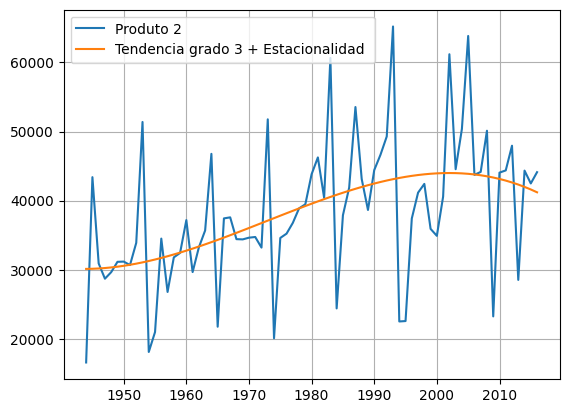

In [ ]:
plt.plot(y,label="Produto 2")
plt.plot(season_pol_3.fittedvalues,label="Tendencia grado 3 + Estacionalidad ")
plt.legend()
plt.grid()

In [ ]:
# Supongamos que ya tienes definidas las variables como en tu código original
h = 7
last_year = train_p2.index[-1].year
num_years = 7

# Generar el rango de fechas con frecuencia anual
range_dates = pd.date_range(start=pd.Timestamp(f"{last_year + 1}-01-01"), periods=num_years, freq='Y')

# Generar características polinómicas para pronosticar
x_for = np.linspace((train_p2.shape[0] + 1), (train_p2.shape[0] + h), h)
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2, x_for**3), axis=1), columns=["x", "x2", "x3"])

# Generar variables dummy para el mes
x_for_dummies = pd.get_dummies(range_dates.month, drop_first=True)

# Concatenar todas las características para el pronóstico
X_for = sm.add_constant(pd.concat([x_for_all, x_for_dummies], axis=1))

# Imprimir el DataFrame resultante
print(X_for)

   const     x      x2        x3
0    1.0  74.0  5476.0  405224.0
1    1.0  75.0  5625.0  421875.0
2    1.0  76.0  5776.0  438976.0
3    1.0  77.0  5929.0  456533.0
4    1.0  78.0  6084.0  474552.0
5    1.0  79.0  6241.0  493039.0
6    1.0  80.0  6400.0  512000.0


In [ ]:
dt = season_pol_3.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds.head(7))

            Point_forecast      lower_95      upper_95
2016-12-31    40760.578188  20072.223052  61448.933323
2017-12-31    40279.636031  19142.781766  61416.490295
2018-12-31    39760.735083  18100.244635  61421.225531
2019-12-31    39203.034536  16937.891571  61468.177501
2020-12-31    38605.693579  15649.453587  61561.933571
2021-12-31    37967.871404  14229.193889  61706.548919
2022-12-31    37288.727202  12671.957627  61905.496776


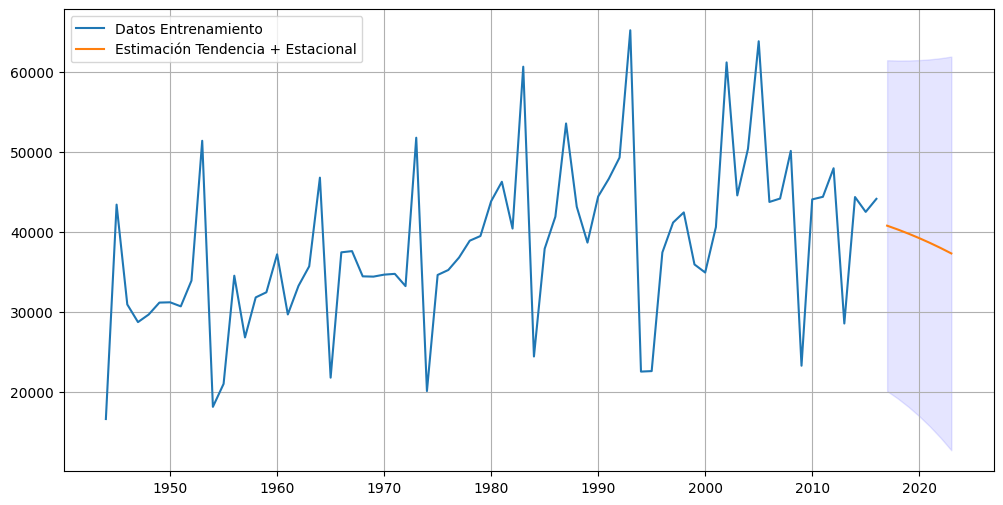

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Tendencia + Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [ ]:
ecm_S_T = mean_squared_error(test_p2, preds.Point_forecast.head(7))
ecm_S_T

208644647.18651122

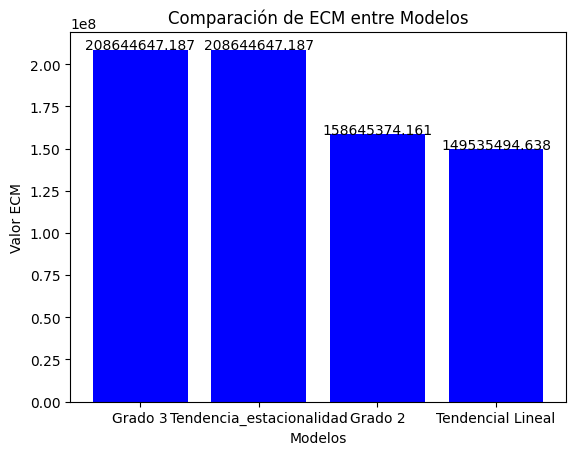

In [ ]:
plt.clf()
model_labels = ['Grado 3', 'Tendencia_estacionalidad','Grado 2', 'Tendencial Lineal']
rmse_values = [ecm_grado3, ecm_S_T, ecm_grado2, ecm_tendencial_lineal]

# Crear el gráfico de barras
plt.bar(model_labels, rmse_values, color='blue')

# Agregar etiquetas y título
plt.xlabel('Modelos')
plt.ylabel('Valor ECM')
plt.title('Comparación de ECM entre Modelos')

# Agregar etiquetas a las barras
for i in range(len(model_labels)):
    plt.text(i, rmse_values[i] + 0.01, f'{rmse_values[i]:.3f}', ha='center')

# Mostrar el gráfico
plt.show()

### Promedio Movil

In [ ]:
train_len = 80-7
train_p1 = data[["ropamujer"]][:train_len]
test_p1 = data[["ropamujer"]][train_len:]

In [ ]:
## Considerando el dato actual
ma_2= train_p1.rolling(2,min_periods=2).mean()
ma_3= train_p1.rolling(3,min_periods=2).mean()
ma_4= train_p1.rolling(4,min_periods=2).mean()
ma_5= train_p1.rolling(5,min_periods=2).mean()

In [ ]:
## Sin considerar el dato actual
ma_2= train_p1.shift().rolling(2,min_periods=2).mean()
ma_3= train_p1.shift().rolling(3,min_periods=2).mean()
ma_4= train_p1.shift().rolling(4,min_periods=2).mean()
ma_5= train_p1.shift().rolling(5,min_periods=2).mean()
ma_7= train_p1.shift().rolling(7,min_periods=2).mean()

In [ ]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [ ]:
ma_2_f= fore_ma(train_p1,2,7)
ma_3_f= fore_ma(train_p1,3,7)
ma_4_f= fore_ma(train_p1,4,7)
ma_5_f= fore_ma(train_p1,5,7)
ma_7_f= fore_ma(train_p1,7,7)

In [ ]:
# Calcular el ECM para cada modelo de media móvil
ecm_ma_2 = mean_squared_error(test_p1, ma_2_f)
ecm_ma_3 = mean_squared_error(test_p1, ma_3_f)
ecm_ma_4 = mean_squared_error(test_p1, ma_4_f)
ecm_ma_5 = mean_squared_error(test_p1, ma_5_f)
ecm_ma_7 = mean_squared_error(test_p1, ma_7_f)
# Imprimir los resultados
print(f"ECM para MA(2): {ecm_ma_2}")
print(f"ECM para MA(3): {ecm_ma_3}")
print(f"ECM para MA(4): {ecm_ma_4}")
print(f"ECM para MA(5): {ecm_ma_5}")
print(f"ECM para MA(5): {ecm_ma_7}")

ECM para MA(2): 159311165.3357578
ECM para MA(3): 158730572.2878576
ECM para MA(4): 169479290.0113183
ECM para MA(5): 171186718.8422921
ECM para MA(5): 174345381.26700205


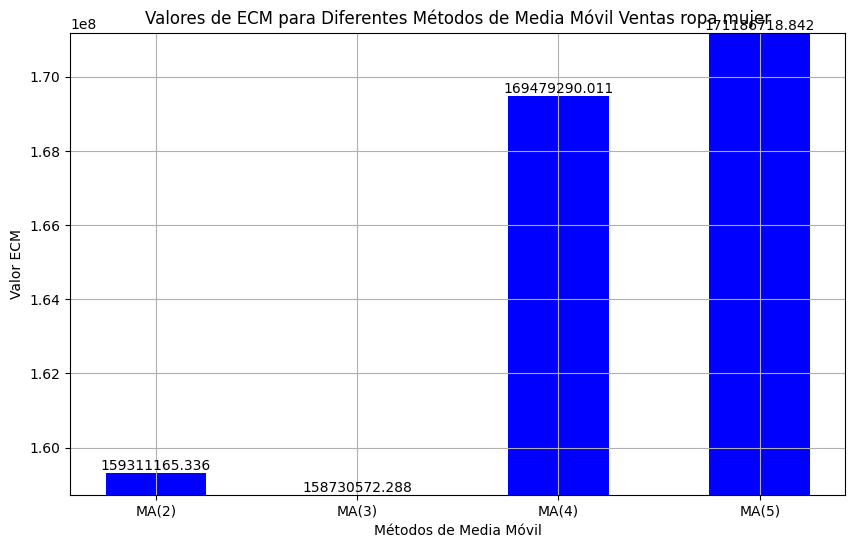

In [ ]:
methods = ['MA(2)', 'MA(3)', 'MA(4)', 'MA(5)']
rmse_values = [ecm_ma_2, ecm_ma_3, ecm_ma_4, ecm_ma_5]

plt.figure(figsize=(10, 6))

# Aumenta el ancho de las barras para mejorar la visibilidad
bars = plt.bar(methods, rmse_values, color='blue', width=0.5)

plt.xlabel('Métodos de Media Móvil')
plt.ylabel('Valor ECM')
plt.title('Valores de ECM para Diferentes Métodos de Media Móvil Ventas ropa mujer')

# Ajusta el límite superior del eje y para mejorar la visualización
plt.ylim(min(rmse_values) - 0.1, max(rmse_values) + 1)

# Agrega etiquetas de datos en la parte superior de las barras
for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f'{value:.3f}', ha='center', va='bottom')

plt.grid()
plt.show()


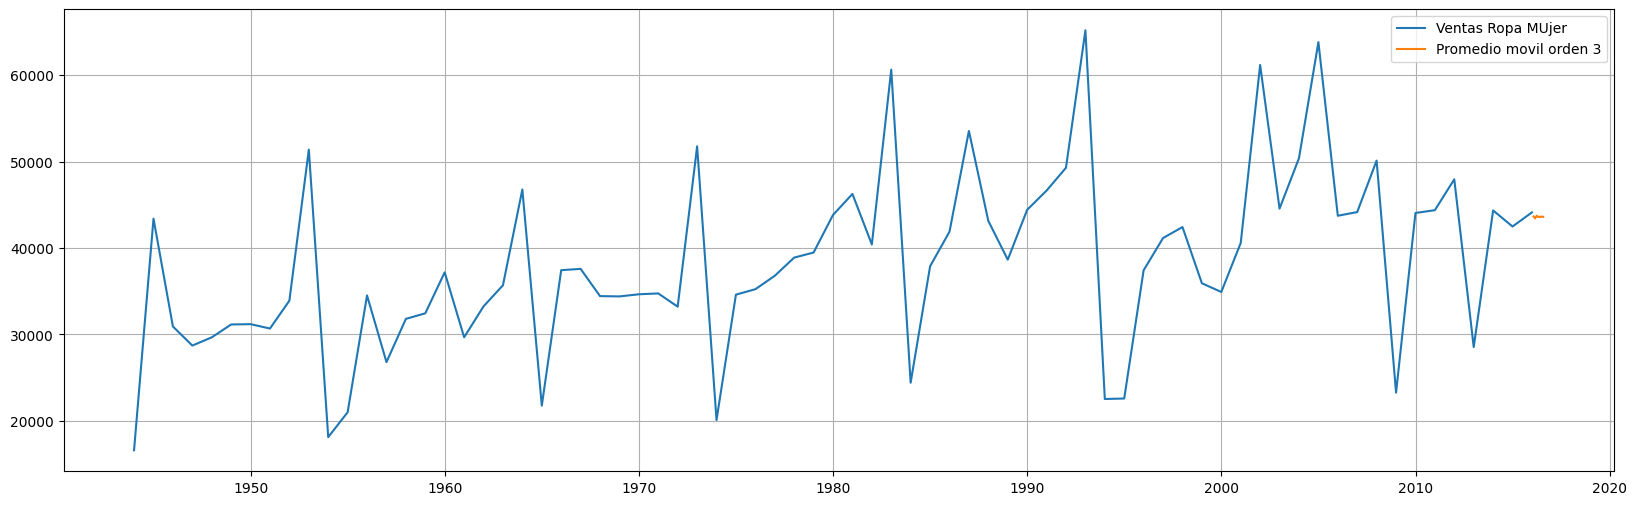

In [ ]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_p1,label="Ventas Ropa MUjer")
plt.plot(ma_3_f,label="Promedio movil orden 3")
plt.legend()
plt.grid()
plt.show()

### Suavizado Exponencial simple Lineal de Winters (Holt-Winters)

In [ ]:
#Construccion del modelo ADIVITVO.
train_len = 80-7
train_p1 = data[["ropamujer"]][:train_len]
test_p1 = data[["ropamujer"]][train_len:]

ets_model = ETSModel(endog=train_p1["ropamujer"], error="add", trend="add", seasonal="add", seasonal_periods=7)
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(7)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

            Point_forecast      lower_95      upper_95
2016-12-31    37868.268148  18804.992881  56931.543416
2017-12-31    44508.491689  25436.552015  63580.431363
2018-12-31    46673.573809  27582.154248  65764.993371
2019-12-31    36997.610809  17871.609900  56123.611717
2020-12-31    42355.665069  23175.756165  61535.573973
2021-12-31    40741.227080  21483.956291  59998.497869
2022-12-31    36256.320275  16894.248542  55618.392008


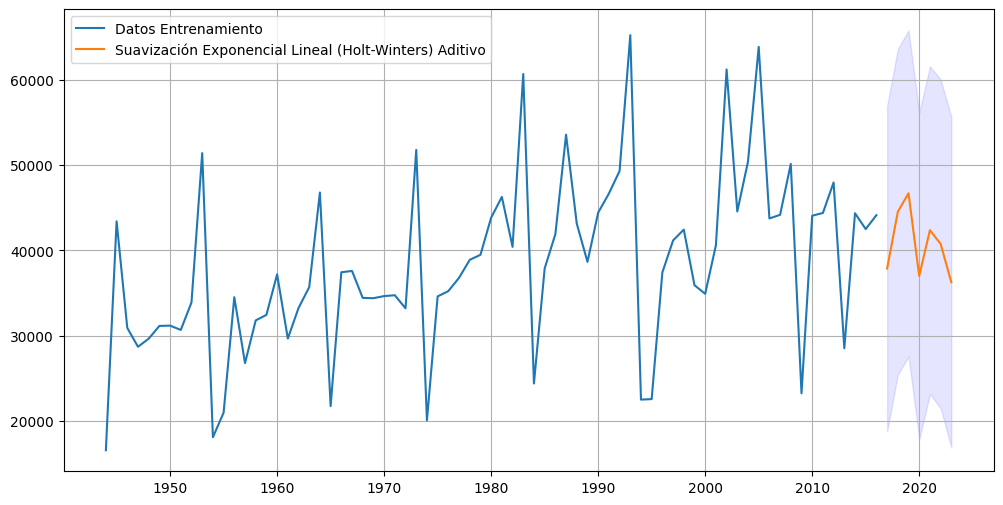

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_p1,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Calcular el ECM
ecm_hw_add = mean_squared_error(test_p1['ropamujer'], preds_hw_add['Point_forecast'])

# Imprimir el resultado
print(f"Error Cuadrático Medio (ECM): {ecm_hw_add}")

Error Cuadrático Medio (ECM): 168174325.41987154


In [ ]:
train_len = 80-7
train_p1 = data[["ropamujer"]][:train_len]
test_p1 = data[["ropamujer"]][train_len:]

In [ ]:
def train_and_evaluate_ECM(error, trend, seasonal, alpha, beta, gamma, seasonal_periods):
    """Entrenar y evaluar el modelo ETS con el objetivo de minimizar el RMSE"""

    # Redondear los valores de alpha, beta, gamma a dos decimales
    alpha, beta, gamma = round(alpha, 2), round(beta, 2), round(gamma, 2)

    # Definir opciones para error, trend y seasonal
    error_options = ["add", "mul"]
    trend_options = ["add", "mul", None]
    seasonal_options = ["add", "mul", None]

    # Configurar el modelo ETS con los hiperparámetros
    model = ETSModel(endog=train_p1["ropamujer"],
                     error=error_options[round(error)],
                     trend=trend_options[round(trend)],
                     seasonal=seasonal_options[round(seasonal)],
                     seasonal_periods=int(round(seasonal_periods)))

    params = {'smoothing_level': alpha, 'smoothing_trend': beta, 'smoothing_seasonal': gamma}

    # Eliminar parámetros si no se aplican (None)
    if trend_options[round(trend)] is None:
        params.pop('smoothing_trend')
    if seasonal_options[round(seasonal)] is None:
        params.pop('smoothing_seasonal')

    # Ajustar el modelo con los parámetros
    model_result = model.fit_constrained(params)

    # Pronosticar los próximos 7 periodos
    point_forecast = model_result.forecast(7)

    # Calcular el ECM
    ecm = mean_squared_error(test_p1["ropamujer"], point_forecast)

    print("ECM: {}, Error: {}, Trend: {}, Seasonal: {}, Seasonal Periods: {}, Alpha: {}, Beta: {}, Gamma: {}".
          format(ecm, error_options[round(error)], trend_options[round(trend)],
                 seasonal_options[round(seasonal)], int(round(seasonal_periods)), alpha, beta, gamma))

    return -ecm


In [ ]:
pbounds = {
    'error': (0, 1),          # Rango para error (0 o 1)
    'trend': (0, 2),          # Rango para trend (0, 1 o 2)
    'seasonal': (0, 2),       # Rango para seasonal (0, 1 o 2)
    'alpha': (0.01,0.99),           # Rango para alpha
    'beta': (0.01,0.99),            # Rango para beta (entre 0 y 1)
    'gamma': (0.01,0.99),           # Rango para gamma (entre 0 y 1)
    'seasonal_periods': (2, 12)  # Rango para seasonal_periods (entre 2 y 12)
}

In [ ]:
optimizer = BayesianOptimization(
    f=train_and_evaluate_ECM,
    pbounds=pbounds,
    random_state=1,
    verbose=2
)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
optimizer.maximize(init_points=3, n_iter=10)

|   iter    |  target   |   alpha   |   beta    |   error   |   gamma   | seasonal  | season... |   trend   |
-------------------------------------------------------------------------------------------------------------
ECM: 4533152504.041699, Error: add, Trend: add, Seasonal: add, Seasonal Periods: 3, Alpha: 0.42, Beta: 0.72, Gamma: 0.31
| 1         | -4.533e+0 | 0.4187    | 0.7159    | 0.0001144 | 0.3063    | 0.2935    | 2.923     | 0.3725    |
ECM: 198491089.00528082, Error: mul, Trend: None, Seasonal: mul, Seasonal Periods: 4, Alpha: 0.35, Beta: 0.4, Gamma: 0.42
| 2         | -1.985e+0 | 0.3486    | 0.3988    | 0.5388    | 0.4208    | 1.37      | 4.045     | 1.756     |
ECM: 194642190.77319768, Error: add, Trend: None, Seasonal: add, Seasonal Periods: 4, Alpha: 0.04, Beta: 0.67, Gamma: 0.56
| 3         | -1.946e+0 | 0.03684   | 0.6671    | 0.4173    | 0.5575    | 0.2808    | 3.981     | 1.601     |
ECM: 118650766.9102494, Error: mul, Trend: None, Seasonal: mul, Seasonal Periods: 5,

In [ ]:
optimal_values = optimizer.max
print("Valor ECM:", -optimal_values['target'])
print("Parámetros óptimos:", optimal_values['params'])


Valor ECM: 118650766.9102494
Parámetros óptimos: {'alpha': 0.01, 'beta': 0.5167011751200831, 'error': 0.7365418819907572, 'gamma': 0.6563985835887076, 'seasonal': 0.7573719962066626, 'seasonal_periods': 4.681536600740986, 'trend': 2.0}


In [ ]:
ecm_Optimizado=-optimal_values['target']

### Autoarima

In [ ]:
train_len = 80-7
train_p1 = data[["ropamujer"]][:train_len]
test_p1 = data[["ropamujer"]][train_len:]

In [ ]:
model = auto_arima(train_p1["ropamujer"],max_p=10, max_q=10,information_criterion = ("aic"))
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   73
Model:               SARIMAX(3, 1, 1)   Log Likelihood                -766.151
Date:                Sat, 13 Jan 2024   AIC                           1544.302
Time:                        22:33:45   BIC                           1557.962
Sample:                    12-31-1943   HQIC                          1549.740
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    414.6762    177.169      2.341      0.019      67.431     761.922
ar.L1         -0.0649      0.143     -0.454      0.650      -0.345       0.215
ar.L2         -0.1655      0.164     -1.009      0.313      -0.487       0.156
ar.L3         -0.0320      0.181     -0.177      0.860      -0.387       0.323
ma.L1         -0.9212      0.094     -9.758      0.000      -1.106      -0.736
sigma2      1.061e+08      0.000   5.22e+11      0.000    1.06e+08    1.06e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 1.75
Prob(Q):                              0.58   Prob(JB):                         0.42
Heteroskedasticity (H):               1.76   Skew:                             0.10
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.94e+27. Standard errors may be unstable.
"""

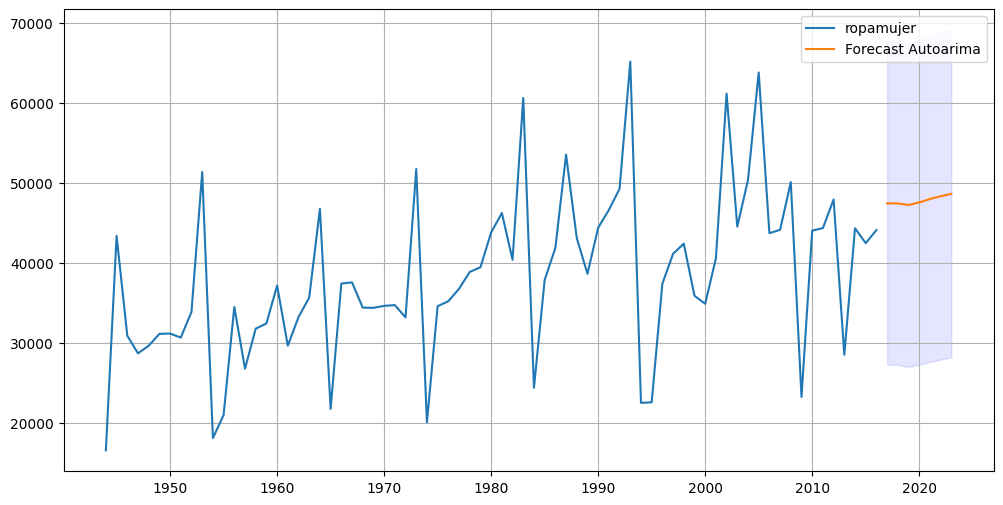

In [ ]:
h=7

y_forec, conf_int  = model.predict(h,return_conf_int=True,alpha=0.05)
preds = pd.DataFrame(np.column_stack([y_forec,conf_int[:,0] , conf_int[:,1]]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']

fig = plt.figure(figsize=(12, 6))
plt.plot(train_p1.index,train_p1["ropamujer"],label="ropamujer")
plt.plot(test_p1.index,preds['Point_forecast'],label="Forecast Autoarima")
plt.fill_between(test_p1.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [ ]:
ecm_autoarima = mean_squared_error(test_p1["ropamujer"], preds["Point_forecast"])
ecm_autoarima

152477848.31743112

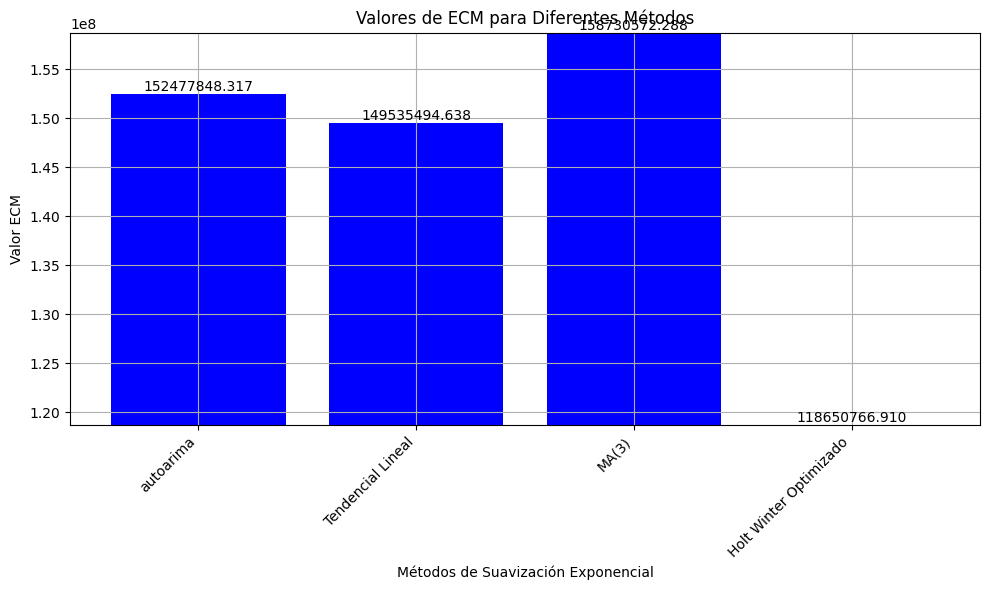

In [ ]:
# Nombres de los métodos
methods = ['autoarima', 'Tendencial Lineal', 'MA(3)', 'Holt Winter Optimizado']

# Valores ECM correspondientes
ecm_values = [ecm_autoarima, ecm_tendencial_lineal, ecm_ma_3, ecm_Optimizado]

# Crear el gráfico
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, ecm_values, color='blue')
plt.xlabel('Métodos de Suavización Exponencial')
plt.ylabel('Valor ECM')
plt.title('Valores de ECM para Diferentes Métodos')
plt.ylim(min(ecm_values) - 0.1, max(ecm_values) + 10)

# Agregar los valores encima de las barras
for bar, value in zip(bars, ecm_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{value:.3f}', ha='center', va='bottom')

# Rotar los nombres de los métodos en el eje x para mayor legibilidad
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.grid()
plt.tight_layout()  # Ajustar el diseño
plt.show()

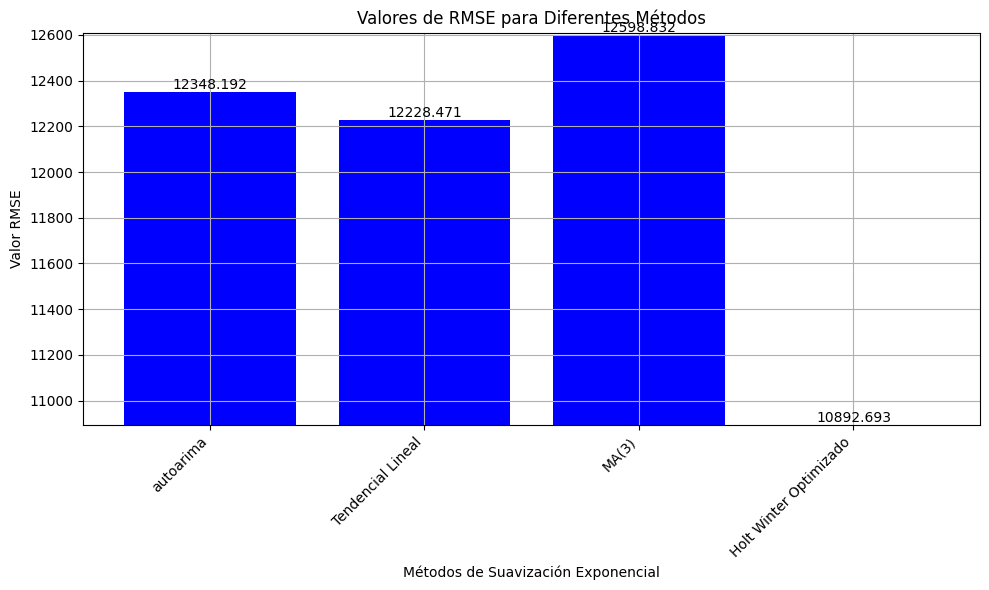

In [ ]:
# Nombres de los métodos
methods = ['autoarima', 'Tendencial Lineal', 'MA(3)', 'Holt Winter Optimizado']

# Valores ECM correspondientes
ecm_values = [ecm_autoarima, ecm_tendencial_lineal, ecm_ma_3, ecm_Optimizado]

# Calcular los valores de RMSE a partir de los valores de ECM
rmse_values = [np.sqrt(ecm) for ecm in ecm_values]

# Crear el gráfico
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, rmse_values, color='blue')
plt.xlabel('Métodos de Suavización Exponencial')
plt.ylabel('Valor RMSE')
plt.title('Valores de RMSE para Diferentes Métodos')
plt.ylim(min(rmse_values) - 0.1, max(rmse_values) + 10)

# Agregar los valores encima de las barras
for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{value:.3f}', ha='center', va='bottom')

# Rotar los nombres de los métodos en el eje x para mayor legibilidad
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.grid()
plt.tight_layout()  # Ajustar el diseño
plt.show()

In [ ]:
window_size = 73  # Tamaño de la ventana de entrenamiento y pronóstico
forecast_steps = 1  # Número de pasos de pronóstico

for i in range(0, 7):
    # Definir los conjuntos de entrenamiento y prueba
    train_subset = train_p1["ropamujer"][:i+window_size]
    test_subset = test_p1["ropamujer"][i:i+forecast_steps]  # Corregir la selección del conjunto de prueba
    # Ajustar el modelo SARIMA con los órdenes y valores estacionales definidos
    model = SARIMAX(train_subset, order=(3, 1, 1), seasonal_order=model.seasonal_order)
    model_fit = model.fit()

    # Realizar pronósticos
    forecast = model_fit.forecast(steps=forecast_steps)

    # Calcular el RMSE
    rmse = mean_squared_error(test_subset, forecast, squared=False)
    print(f"Pronostico {i+1}: RMSE = {rmse}")

Pronostico 1: RMSE = 1742.0673249749161
Pronostico 2: RMSE = 752.6273249749138
Pronostico 3: RMSE = 8804.702675025088
Pronostico 4: RMSE = 8494.062675025081
Pronostico 5: RMSE = 5485.5426750250845
Pronostico 6: RMSE = 26722.532675025082
Pronostico 7: RMSE = 16742.787324974914


In [ ]:
# Obtener los parámetros óptimos del diccionario
optimal_params = {'alpha': 0.01, 'beta': 0.5167011751200831, 'error': 0.7365418819907572, 'gamma': 0.6563985835887076, 'seasonal': 0.7573719962066626, 'seasonal_periods': 4.681536600740986, 'trend': 2.0}

# Configurar el modelo ETS con los parámetros óptimos
model = ETSModel(endog=train_p1["ropamujer"],
                 error="add",  # Reemplaza con el valor óptimo de error
                 trend="add",  # Reemplaza con el valor óptimo de trend
                 seasonal="add",  # Reemplaza con el valor óptimo de seasonal
                 seasonal_periods=int(round(optimal_params['seasonal_periods'])))

# Ajustar el modelo con los parámetros óptimos
model_result = model.fit(smoothing_level=optimal_params['alpha'],
                         smoothing_trend=optimal_params['beta'],
                         smoothing_seasonal=optimal_params['gamma'])

window_size = 73  # Tamaño de la ventana de entrenamiento y pronóstico
forecast_steps = 7  # Número de pasos de pronóstico

for i in range(0, forecast_steps):
    # Definir los conjuntos de entrenamiento y prueba
    train_subset = train_p1["ropamujer"][:i + window_size]
    test_subset = test_p1["ropamujer"][i:i + 1]  # Seleccionar solo un paso de pronóstico

    # Realizar pronósticos con el modelo ETS
    forecast_ets = model_result.forecast(steps=1)
    #print(forecast_ets, test_subset)

    # Calcular el RMSE
    rmse_ets = mean_squared_error(test_subset, forecast_ets, squared=False)
    print(f"Pronóstico {i + 1}: RMSE ETS = {rmse_ets}")

Pronóstico 1: RMSE ETS = 8787.09972584821
Pronóstico 2: RMSE ETS = 7797.659725848207
Pronóstico 3: RMSE ETS = 1759.6702741517947
Pronóstico 4: RMSE ETS = 1449.030274151788
Pronóstico 5: RMSE ETS = 1559.4897258482088
Pronóstico 6: RMSE ETS = 19677.50027415179
Pronóstico 7: RMSE ETS = 23787.819725848207


#### Validacion de supuestos del modelo ARIMA

## Autocorrelacion
Autocorrelación
Para determinar si existe autocorrelación vamos a usar la prueba de rachas propuesta por Wald y Wolfowitz, 1940. Es una prueba no paramétrica donde las hipótesis son las siguientes:

𝐻0:ρ=0
  (Es decir no hay autocorrelación)

𝐻1:ρ≠0
  (Es decir hay autocorrelación)

Rechazo  𝐻0
  cuando el p-valor es menor al nivel de significancia, convencionalmente se usa un  α
 =0.05 ( α
  = nivel de significancia).

In [ ]:
model = auto_arima(train_p1["ropamujer"],max_p=10, max_q=10,information_criterion = ("aic"))

In [ ]:
model = SARIMAX(train_p1["ropamujer"], order=(3, 1, 1), seasonal_order=model.seasonal_order)
model_fit = model.fit()
residuals = model_fit.resid
runstest_1samp(residuals[2:], correction=False)

(-1.1389045590952167, 0.2547429638637656)

In [ ]:
## No hay autocorrelacion en los residuales

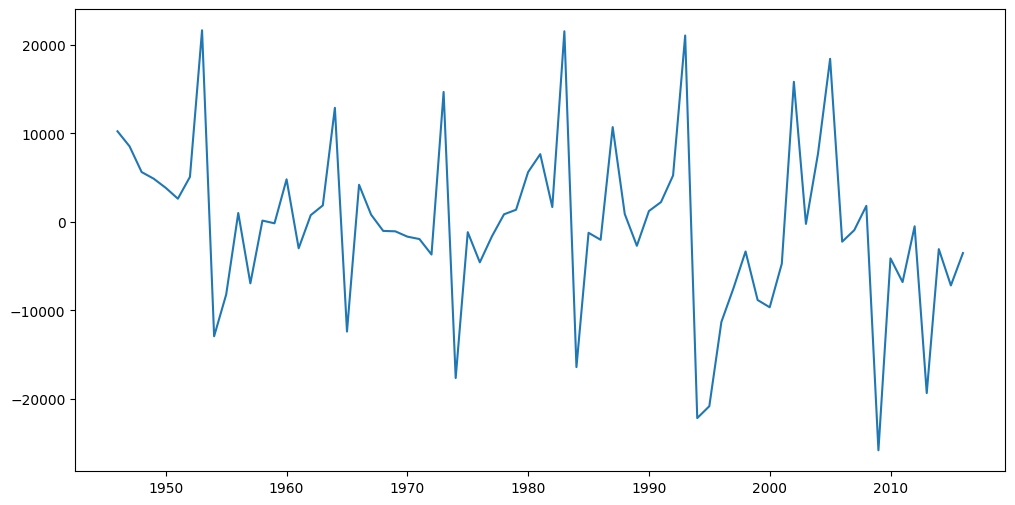

In [ ]:
model = auto_arima(train_p1["ropamujer"],max_p=10, max_q=10,information_criterion = ("aic"))
fig = plt.figure(figsize=(12, 6))
plt.plot(model.resid()[2:],label="Residuales")

In [ ]:
Resul_lb_bp = sm.stats.acorr_ljungbox(residuals[2:], lags=range(1,20), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,0.258970,0.610828,0.248328,0.618255,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
2,0.376480,0.828416,0.359399,0.835521,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
3,0.402775,0.939669,0.383893,0.943549,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
4,0.403562,0.982184,0.384615,0.983717,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
5,0.507415,0.991849,0.478510,0.992889,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
6,0.508936,0.997728,0.479864,0.998075,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
7,3.323651,0.853536,2.947559,0.889811,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
8,8.599029,0.377241,7.500282,0.483738,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
9,9.203048,0.418746,8.013285,0.532808,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
10,11.261010,0.337548,9.732951,0.464227,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr


In [ ]:
# Calcular el estadístico de Durbin-Watson
durbin_watson_statistic = durbin_watson(residuals[2:])

print(f"Estadístico de Durbin-Watson: {durbin_watson_statistic}")

Estadístico de Durbin-Watson: 2.011648543129276


SE CUMPLE SUPUESTO

###  Homoscedasticidad y Heteroscedasticidad**

Ahora nos queda por chequear si existe problemas de heteroscedasticidad, en
especial un comportamiento tipo ARCH o GARCH, esto implica que la varianza de la serie tenga un comportamiento no autocorrelacionado.

Una aproximación para determinar si existe un comportamiento GARCH o
ARCH es emplear la prueba de Ljung-Box sobre la serie (sin media) al cuadrado.

$H{0}:$ Comportamiento Homoscedastico (Es decir varianza constante)

$H{1}:$ Comportamiento Heteroscedastico (Es decir varianza no constante)

In [ ]:
Resul_lb_bp= sm.stats.acorr_ljungbox((residuals[2:]-residuals[2:].mean())**2, lags=range(1,21), return_df=True,boxpierce=True )

Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,4.021223,0.044931,3.855967,0.049569
2,4.860182,0.088029,4.648956,0.097835
3,6.769294,0.079626,6.427307,0.092574
4,6.770516,0.148524,6.428428,0.169356
5,11.575715,0.041087,10.772855,0.056074
6,15.101937,0.019479,13.912641,0.030627
7,15.131018,0.034356,13.938138,0.052293
8,15.134343,0.056585,13.941007,0.083316
9,16.423844,0.058541,15.036199,0.089946
10,22.604474,0.012305,20.200835,0.027409


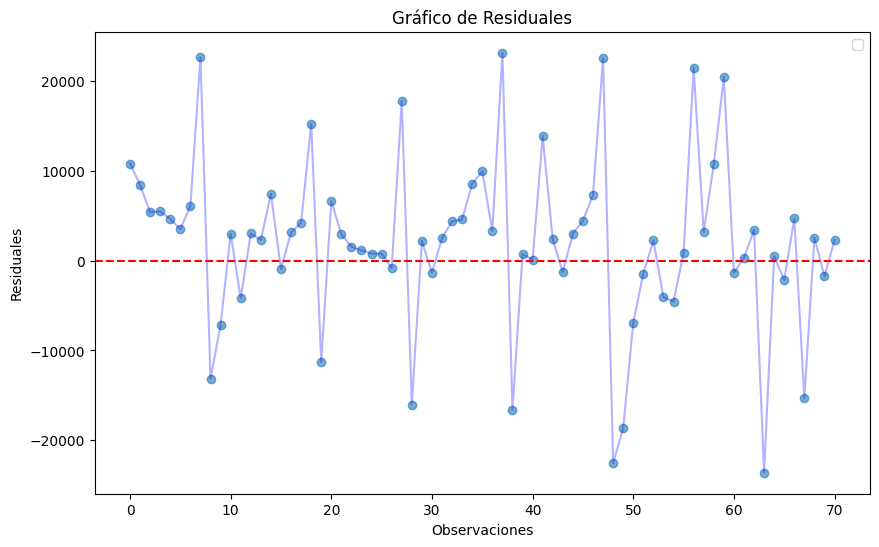

In [ ]:
# Crear un gráfico de dispersión de los residuales
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals[2:])), residuals[2:], alpha=0.6)
plt.plot(range(len(residuals[2:])), residuals[2:], 'b-', alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Gráfico de Residuales')
plt.xlabel('Observaciones')
plt.ylabel('Residuales')
plt.legend()
plt.show()

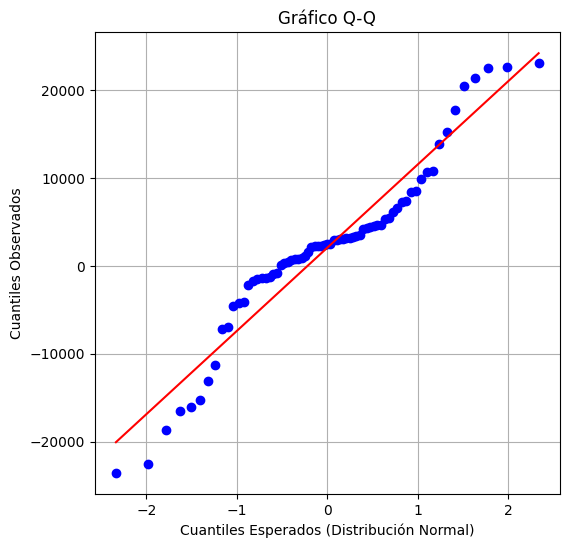

In [ ]:
## prueba normalidad
plt.figure(figsize=(6, 6))
stats.probplot(residuals[2:], plot=plt)
plt.xlabel('Cuantiles Esperados (Distribución Normal)')
plt.ylabel('Cuantiles Observados')
plt.title('Gráfico Q-Q')
plt.grid(True)
plt.show()

In [ ]:
statistic, p_value = stats.shapiro(residuals[2:])

print("Estadística de prueba:", statistic)
print("Valor p:", p_value)

alpha = 0.05
if p_value > alpha:
    print("Los datos siguen una distribución normal (no se rechaza la hipótesis nula).")
else:
    print("Los datos no siguen una distribución normal (se rechaza la hipótesis nula).")

Estadística de prueba: 0.9315271377563477
Valor p: 0.0007999250083230436
Los datos no siguen una distribución normal (se rechaza la hipótesis nula).


## Red Neuronal LSTM

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 4.3 MB/s eta 0:00:00


In [ ]:
import os, random, math, time
import requests
from zipfile import ZipFile
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
import torchmetrics

In [ ]:
if torch.cuda.is_available():
    print("Utilizamos la primera GPU disponible")
    DEVICE=device = torch.device('cuda:0')
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
else:
    print("No hay GPU, toca correr todo en CPU")
    DEVICE=device = torch.device('cpu')

DEVICE

Utilizamos la primera GPU disponible


device(type='cuda', index=0)

In [ ]:
def reset_seed():
    SEED = 42
    torch.backends.cudnn.enabled = True
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
TRAIN_SPLIT = 80-20

In [ ]:
# Detecta la codificación del archivo CSV
with open('ventas_train.csv', 'rb') as f:
    result = chardet.detect(f.read())

# Abre el archivo CSV en modo lectura con la codificación detectada
with open('ventas_train.csv', 'r', encoding=result['encoding']) as archivo_csv:
    # Utiliza pandas para crear un DataFrame a partir del archivo CSV
    data = pd.read_csv(archivo_csv)
# Elimina la columna ID de df
data.drop('ID', axis=1, inplace=True)

In [ ]:
start_date = '1943-01-01'

# Crea un rango de fechas con las fechas de inicio y fin especificadas, con frecuencia anual ('A')
date_range = pd.date_range(start=start_date, periods=len(data), freq='A')

# Asigna el rango de fechas como el nuevo índice al DataFrame existente
data.index = date_range

In [ ]:
df=data.copy()

In [ ]:
## Se toman todas las variables de data
variables_a_considerar = ['ropamujer', 'correo', 'páginas', 'teléfono', 'impresa', 'servicio',
        'edadloc', 'promo', 'nomina']

In [ ]:
features = df[variables_a_considerar]
features.head()

,ropamujer,correo,páginas,teléfono,impresa,servicio,edadloc,promo,nomina
1943-12-31,16578.93,7978,73,34,22294.48,20,7,3,26780
1944-12-31,43393.55,8029,65,24,27978.66,26,1,2,24789
1945-12-31,30908.49,7752,85,20,28949.65,22,6,2,25121
1946-12-31,28701.58,8685,74,17,22642.27,21,10,1,27648
1947-12-31,29647.57,7847,87,30,27210.61,23,5,3,25982


In [ ]:
features.shape

(80, 9)

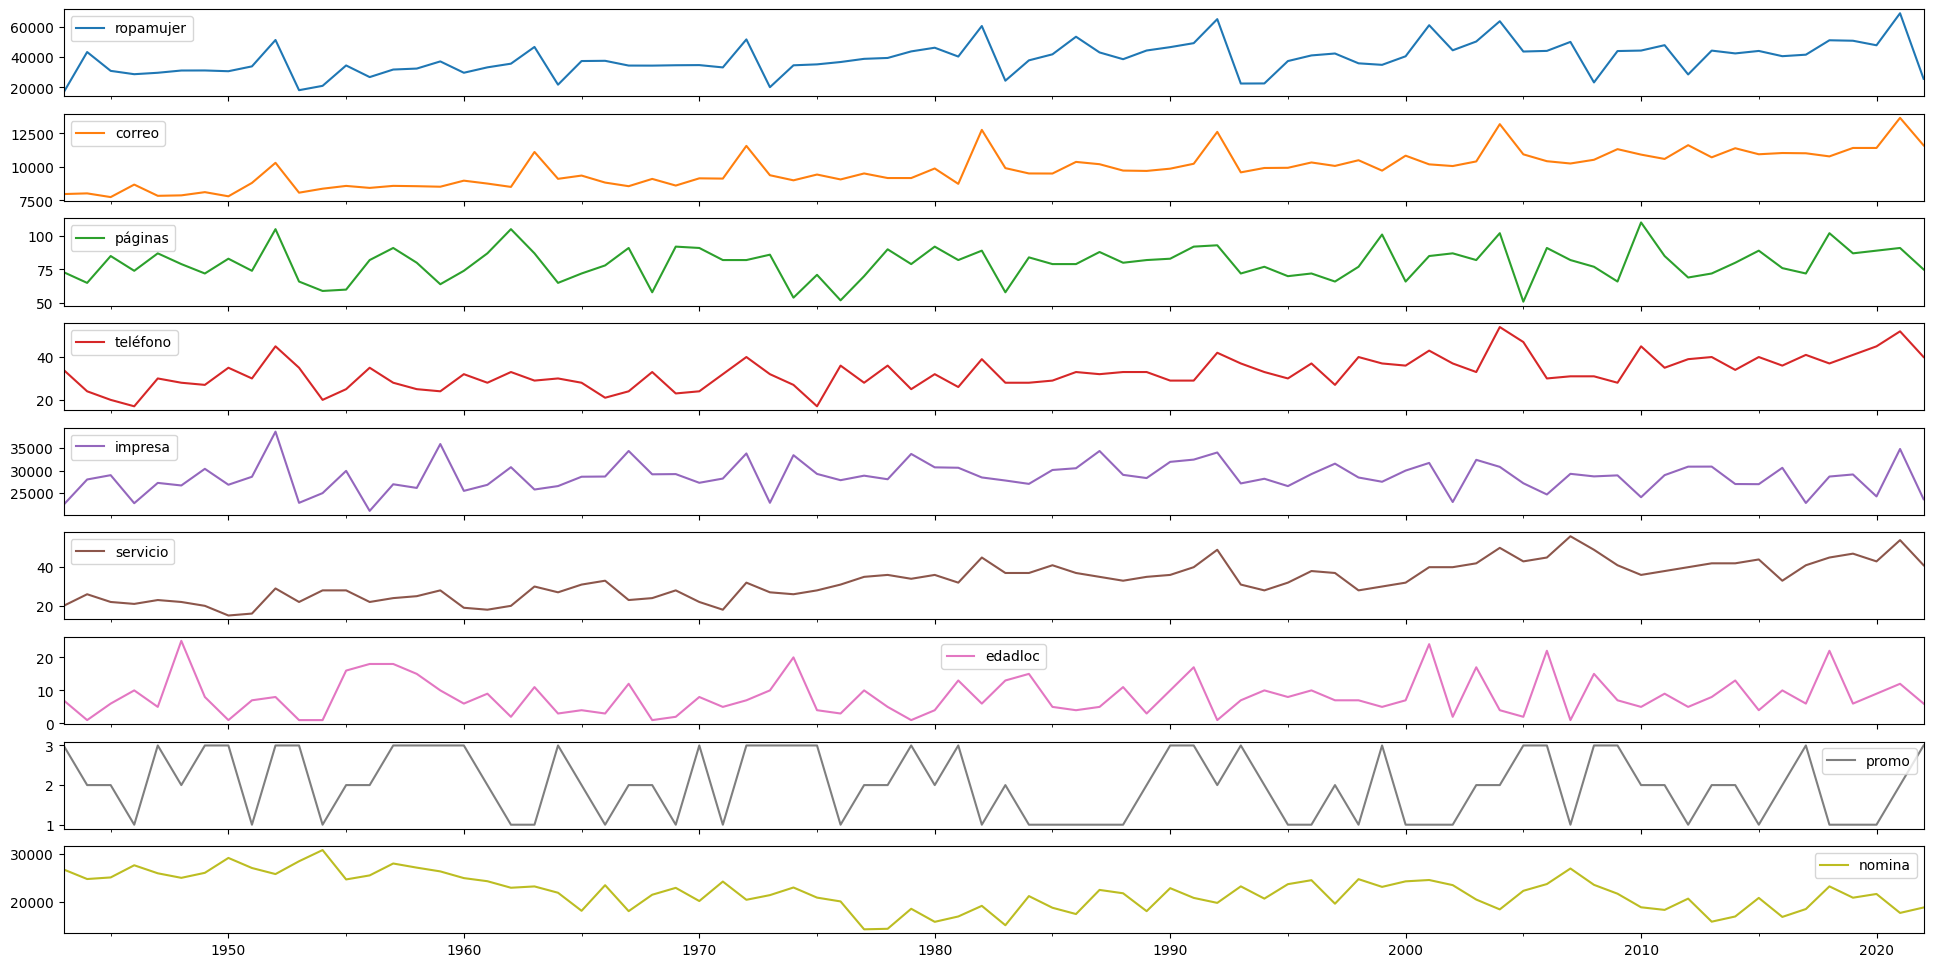

In [ ]:
_=features.plot(subplots=True, figsize=(24,12))

In [ ]:
dataset = features.values
promedios = dataset[:TRAIN_SPLIT].mean(axis=0)
desviaciones = dataset[:TRAIN_SPLIT].std(axis=0)

In [ ]:
dataset = (dataset-promedios)/desviaciones

In [ ]:
class SerieTiempoMultivariadaDataset(Dataset):
    def __init__(self, dataset, target, start_index, end_index,
                 history_size, target_size, step, single_step=False):
        data = []
        labels = []

        start_index = start_index + history_size
        if end_index is None:
            end_index = len(dataset) - target_size

        for i in range(start_index, end_index):
            indices = range(i-history_size, i, step)
            data.append(dataset[indices])

            if single_step:
                labels.append([target[i+target_size]])
            else:
                labels.append(target[i:i+target_size])

        self.data = torch.FloatTensor(np.array(data))
        self.labels = torch.FloatTensor(np.array(labels))


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if (idx >= len(self.data)) or (idx < 0):
            raise Exception("Out of bounds: idx=", idx)
        return self.data[idx], self.labels[idx]

In [ ]:
dataset[:,0]

array([-2.0976754 ,  0.50138026, -0.70875682, -0.92266557, -0.83097377,
       -0.68617093, -0.68270095, -0.73164318, -0.41967938,  1.27528754,
       -1.94994633, -1.67114217, -0.36034079, -1.10853436, -0.62330032,
       -0.56101612, -0.1008745 , -0.82988044, -0.48292025, -0.2463345 ,
        0.8283522 , -1.59619061, -0.07693648, -0.06226564, -0.36800091,
       -0.37138463, -0.34736326, -0.33784892, -0.4864765 ,  1.31239501,
       -1.75848292, -0.35125487, -0.29084911, -0.13983811,  0.06416279,
        0.12091344,  0.54242488,  0.77831664,  0.21130932,  2.17327666,
       -1.33953034, -0.03310811,  0.35507795,  1.48494315,  0.47594763,
        0.0410186 ,  0.60023591,  0.81600469,  1.07210859,  2.61470075,
       -1.52248746, -1.51666119, -0.07818587,  0.28402188,  0.40688824,
       -0.22380871, -0.32170576,  0.22881915,  2.22528662,  0.61321635,
        1.1781    ,  2.48160085,  0.53366561,  0.5750456 ,  1.1525026 ,
       -1.45142847,  0.56488283,  0.5960603 ,  0.94233328, -0.93

In [ ]:
dataset.shape

(80, 9)

In [ ]:
TRAIN_SPLIT

60

In [ ]:
past_history = 20 # Los 20 anos anteriores
future_target =4  # Valor dentro de 4 anos
STEP = 2 # Valores cada ano
TRAIN_SPLIT=50

train_data = SerieTiempoMultivariadaDataset(dataset, dataset[:, 0], 0, TRAIN_SPLIT,
                                                   past_history, future_target,
                                                   STEP, single_step=True)
val_data = SerieTiempoMultivariadaDataset(dataset, dataset[:, 0], TRAIN_SPLIT, None,
                                               past_history, future_target,
                                               STEP, single_step=True)

In [ ]:
len(val_data)


6

In [ ]:
ventana_historica = past_history / STEP

In [ ]:
ventana_historica

10.0

In [ ]:
train_data[0][0].shape

torch.Size([10, 9])

In [ ]:
train_data[0][1].shape

torch.Size([1])

In [ ]:
BATCH_SIZE=16

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(GRUModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim

        # Módulo recurrente
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True).to(DEVICE)

        # capa de salida
        self.fc = nn.Linear(hidden_dim, output_dim).to(DEVICE)

    def forward(self, x):
        # Definimos los estados iniciales a considerar en lo módulo recurrente,
        # con un tensor de la forma (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(DEVICE)

        # Procesamos los datos del batch a través del módulo recurrente
        out, hn = self.gru(x, h0.detach())

        # El tensor "out" tiene sus ejes (batch_size, timesteps, output_features)
        # con los estados escondidos de todos los pasos de tiempo. La capa
        # densa final, solo recibirá el último paso de tiempo.
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim

        # Módulo recurrente
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu').to(DEVICE)

        # capa de salida
        self.fc = nn.Linear(hidden_dim, output_dim).to(DEVICE)

    def forward(self, x):
        # Definimos los estados iniciales a considerar en lo módulo recurrente,
        # con un tensor de la forma (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(DEVICE)

        # Procesamos los datos del batch a través del módulo recurrente
        out, hn = self.rnn(x, h0.detach())

        # El tensor "out" tiene sus ejes (batch_size, timesteps, output_features)
        # con los estados escondidos de todos los pasos de tiempo. La capa
        # densa final, solo recibirá el último paso de tiempo.
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim

        # Módulo recurrente
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True).to(DEVICE)
        # capa de salida
        self.fc = nn.Linear(hidden_dim, output_dim).to(DEVICE)

    def forward(self, x):
        # Definimos los estados iniciales a considerar en lo módulo recurrente,
        # con un tensor de la forma (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(DEVICE)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(DEVICE)

        # Procesamos los datos del batch a través del módulo recurrente
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # El tensor "out" tiene sus ejes (batch_size, timesteps, output_features)
        # con los estados escondidos de todos los pasos de tiempo. La capa
        # densa final, solo recibirá el último paso de tiempo.
        out = self.fc(out[:, -1, :])

        return out

In [ ]:
def train_model_forecasting(modelo, train_dataset, val_dataset, batch_size=32, learning_rate = 1e-3, epocas=30, verbose=False):
    """Se encarga de realizar el ciclo de épocas de entrenamiento de un modelo de forecasting.

    :modelo:
        instancia creada del modelo a entrenar
    :train_dataset:
        instancia de Dataset con los datos de entrenamiento
    :train_dataset:
        instancia de Dataset con los datos de validación
    :batch_size:
        tamaño del batch size de entrenamiento
    :learning_rate:
        learning rate del optimizador.
    :epocas:
        número de iteraciones de entrenamiento sobre el dataset completo
    :verbose:
        indica si se quiere imprimr el avance del proceso o no
    :returns:
        el modelo entrenado y 4 arrays con los valores de losses y accuracies del training dataset, y los losses del val set después de cada época
    """

    reset_seed()

    # Gestión de los loaders de training y validation
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Se crea el modelo y optimizador
    modelo = modelo.to(DEVICE) # situar el modelo en el dispositivo de procesamiento
    loss_fn = nn.MSELoss() # se usa una función de pérdida de regresión
    optimizer = torch.optim.Adam(modelo.parameters(), lr=learning_rate)

    # Creamos vectores donde almacenaremos los losses y métricas después de cada época
    train_losses = [0] * epocas
    val_losses = [0] * epocas

    for epoca in range(epocas):
        epoca_start_time = time.time()
        modelo.train()
        for batch_features, batch_labels in train_loader:
            # Nos aseguramos que los inputs del modelo estén en el mismo dispositivo
            batch_features = batch_features.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE)
            # Generar las predicciones
            batch_preds = modelo(batch_features)
            # Comparar con las realidades a partir del loss function
            loss = loss_fn(batch_preds, batch_labels)
            # Calcular los gradientes de la función de pérdida
            loss.backward()
            # Actualizar parámetros con los gradientes
            optimizer.step()
            # Resetear los gradientes para no reacumularlos
            optimizer.zero_grad()
            # se acumulan los losses de la epoca (ponderados por el tamaño del batch)
            train_losses[epoca] += loss.item() * batch_labels.size(0)

        # se normaliza el loss del training set
        train_losses[epoca] /= len(train_loader.dataset)

        # se desactiva la diferenciación automática para la inferencia sobre el val set
        modelo.eval()
        with torch.no_grad():
            for batch_features, batch_labels in val_loader:
                # Nos aseguramos que los inputs del modelo estén en el mismo dispositivo
                batch_features = batch_features.to(DEVICE)
                batch_labels = batch_labels.to(DEVICE)
                # Generar las predicciones
                batch_preds = modelo(batch_features)
                # Comparar con las realidades a partir del loss function
                loss = loss_fn(batch_preds, batch_labels)
                # se acumulan los losses de la epoca (ponderados por el tamaño del batch)
                val_losses[epoca] += loss.item() * batch_labels.size(0)

        # se normalizan el loss del val set
        val_losses[epoca] /= len(val_loader.dataset)

        epoca_end_time = time.time()
        segundos = epoca_end_time - epoca_start_time

        if verbose:
            print(f"{epoca}:  loss: {train_losses[epoca]:>7f}, val loss: {val_losses[epoca]:>7f}",
                    f"-- epoch time: {segundos:.2f}")
    return modelo, train_losses, val_losses

In [ ]:
def plot_losses(train_losses, val_losses=None):
    plt.figure(figsize=(6, 3), dpi=120)

    plt.plot(train_losses)
    if val_losses is not None:
        plt.plot(val_losses)
        plt.legend(['train', 'val'], loc='upper left')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('model loss')

    _=plt.show()

In [ ]:
def plot_reals_vs_preds(reals, preds):
    num_puntos = len(reals)
    plt.figure(figsize=(12, 5))

    plt.scatter(np.arange(num_puntos), reals, color = 'blue', marker = ".")
    plt.scatter(np.arange(num_puntos), preds, color = 'green', marker = ".")
    plt.title("Valores reales vs. predichos")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(['reals', 'preds'], loc='upper left')

    _=plt.show()

In [ ]:
def pronostico(modelo, forecast_dataset, batch_size):
    modelo.eval()
    preds_loader = DataLoader(forecast_dataset, batch_size=batch_size, shuffle=False)
    preds = torch.empty((0)).to(DEVICE)
    with torch.no_grad():
        for batch_idx, (batch_features, batch_labels) in enumerate(preds_loader):
            batch_features = batch_features.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE).unsqueeze(-1).float()
            batch_preds = torch.squeeze(modelo(batch_features), -1)
            preds = torch.concatenate((preds, batch_preds), axis=0)
            # print(f"batch: {batch_idx}\npreds:{len(preds)}")
    return preds

In [ ]:
past_history = 20 # Los 20 anos anteriores
future_target =4  # Valor dentro de 4 anos
STEP = 2 # Valores cada hora

train_data = SerieTiempoMultivariadaDataset(dataset, dataset[:, 0], 0, TRAIN_SPLIT,
                                                   past_history, future_target,
                                                   STEP, single_step=True)
val_data = SerieTiempoMultivariadaDataset(dataset, dataset[:, 0], TRAIN_SPLIT, None,
                                               past_history, future_target,
                                               STEP, single_step=True)

In [ ]:
len(val_data)

0

In [ ]:
def proceso_completo(modelo='lstm', past_history = 20, future_target = 4, step=2, num_capas=1, num_hidden=5, showPlots=False):
    reset_seed()
    train_data = SerieTiempoMultivariadaDataset(dataset, dataset[:, 0], 0, TRAIN_SPLIT,
                                                    past_history, future_target,
                                                    step, single_step=True)
    val_data = SerieTiempoMultivariadaDataset(dataset, dataset[:, 0], TRAIN_SPLIT, None,
                                                past_history, future_target,
                                                step, single_step=True)

    if modelo=='rnn':
        modelo_forecasting = \
            RNNModel(input_dim=num_features, hidden_dim=int(num_hidden),\
                     layer_dim=num_capas, output_dim=num_outputs)
        (modelo_forecasting, train_losses, val_losses) = \
            train_model_forecasting(modelo_forecasting, train_data, val_data,\
                                    batch_size=BATCH_SIZE, learning_rate=1e-3,\
                                    epocas=5)
    elif modelo=='lstm':
        modelo_forecasting = \
            LSTMModel(input_dim=num_features, hidden_dim=int(num_hidden),\
                      layer_dim=num_capas, output_dim=num_outputs)
        (modelo_forecasting, train_losses, val_losses) = \
            train_model_forecasting(modelo_forecasting, train_data, val_data, \
                                    batch_size=BATCH_SIZE, learning_rate=1e-3,\
                                    epocas=5)
    elif modelo=='gru':
        modelo_forecasting = \
            GRUModel(input_dim=num_features, hidden_dim=int(num_hidden), \
                     layer_dim=num_capas, output_dim=num_outputs)
        (modelo_forecasting, train_losses, val_losses) = \
            train_model_forecasting(modelo_forecasting, train_data, val_data,\
                                    batch_size=BATCH_SIZE, learning_rate=1e-3,\
                                    epocas=5)
    else:
        raise Exception("Modelo invalido: ", modelo)

    preds = pronostico(modelo_forecasting, val_data, BATCH_SIZE).cpu().numpy()
    reals = torch.squeeze(val_data.labels)

    print(f"last val loss: {val_losses[-1]}")

    if showPlots:
        plot_losses(train_losses, val_losses)
        plot_reals_vs_preds(reals, preds)

    return modelo_forecasting, past_history, train_losses[-1], val_losses[-1]

In [ ]:
reset_seed()
lstm = nn.LSTM(input_size=5, hidden_size=3, num_layers=1, batch_first=True)

In [ ]:
x_seq = torch.tensor([[1.0]*5, [2.0]*5, [3.0]*5]).float()
print(x_seq.shape)
print(x_seq)

torch.Size([3, 5])
tensor([[1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.]])


In [ ]:
lstm(torch.reshape(x_seq, (1, 3, 5)))

(tensor([[[-0.0170,  0.0160,  0.2735],
          [ 0.0645,  0.0477,  0.4026],
          [ 0.2172,  0.0411,  0.4880]]], grad_fn=<TransposeBackward0>),
 (tensor([[[0.2172, 0.0411, 0.4880]]], grad_fn=<StackBackward0>),
  tensor([[[0.6542, 0.5372, 1.0005]]], grad_fn=<StackBackward0>)))

In [ ]:
output, (hn, cn) = lstm(torch.reshape(x_seq, (1, 3, 5)))
print("output:", output.shape, "\n  ",output)
print("hn:", hn.shape, "\n  ", hn)
print("cn:", cn.shape, "\n  ", hn)

output: torch.Size([1, 3, 3]) 
   tensor([[[-0.0170,  0.0160,  0.2735],
         [ 0.0645,  0.0477,  0.4026],
         [ 0.2172,  0.0411,  0.4880]]], grad_fn=<TransposeBackward0>)
hn: torch.Size([1, 1, 3]) 
   tensor([[[0.2172, 0.0411, 0.4880]]], grad_fn=<StackBackward0>)
cn: torch.Size([1, 1, 3]) 
   tensor([[[0.2172, 0.0411, 0.4880]]], grad_fn=<StackBackward0>)


In [ ]:
features

,ropamujer,correo,páginas,teléfono,impresa,servicio,edadloc,promo,nomina
1943-12-31,16578.93,7978,73,34,22294.48,20,7,3,26780
1944-12-31,43393.55,8029,65,24,27978.66,26,1,2,24789
1945-12-31,30908.49,7752,85,20,28949.65,22,6,2,25121
1946-12-31,28701.58,8685,74,17,22642.27,21,10,1,27648
1947-12-31,29647.57,7847,87,30,27210.61,23,5,3,25982
...,...,...,...,...,...,...,...,...,...
2018-12-31,51194.98,10789,102,37,28642.16,45,22,1,23263
2019-12-31,50884.34,11419,87,41,29108.63,47,6,1,20910
2020-12-31,47875.82,11419,89,45,24164.44,43,9,1,21683
2021-12-31,69112.81,13666,91,52,34843.65,54,12,2,17745


In [ ]:
num_features = 9
num_hidden_neurons_per_layer = 5
num_layers = 2
num_outputs = 1

In [ ]:
resultados_lstm = []
for neuronas in np.arange(10, 61, 10):
    modelo_start_time = time.time()
    print(f"Proceso para {neuronas} neuronas escondidas")
    resultados_lstm.append(proceso_completo( \
        modelo='lstm', past_history=20, future_target=4, step=2,
        num_capas=1, num_hidden=neuronas, showPlots=False)[1:])
    modelo_end_time = time.time()
    segundos = modelo_end_time - modelo_start_time
    print(f"  tomó {segundos:.2f} segundos")

Proceso para 10 neuronas escondidas
last val loss: 2.014141082763672
  tomó 0.04 segundos
Proceso para 20 neuronas escondidas
last val loss: 1.9011151790618896
  tomó 0.04 segundos
Proceso para 30 neuronas escondidas
last val loss: 2.257678270339966
  tomó 0.04 segundos
Proceso para 40 neuronas escondidas
last val loss: 2.2249796390533447
  tomó 0.04 segundos
Proceso para 50 neuronas escondidas
last val loss: 2.258596897125244
  tomó 0.04 segundos
Proceso para 60 neuronas escondidas
last val loss: 2.3384335041046143
  tomó 0.04 segundos


In [ ]:
resultados_gru = []
for neuronas in np.arange(10, 61, 10):
    modelo_start_time = time.time()
    print(f"Proceso para {neuronas} neuronas escondidas")
    resultados_gru.append(proceso_completo( \
        modelo='gru', past_history=20, future_target=4, step=2,
        num_capas=1, num_hidden=neuronas, showPlots=False)[1:])
    modelo_end_time = time.time()
    segundos = modelo_end_time - modelo_start_time
    print(f"  tomó {segundos:.2f} segundos")

Proceso para 10 neuronas escondidas
last val loss: 2.0452494621276855
  tomó 0.08 segundos
Proceso para 20 neuronas escondidas
last val loss: 2.4850645065307617
  tomó 0.03 segundos
Proceso para 30 neuronas escondidas
last val loss: 2.0240120887756348
  tomó 0.04 segundos
Proceso para 40 neuronas escondidas
last val loss: 2.363079309463501
  tomó 0.04 segundos
Proceso para 50 neuronas escondidas
last val loss: 2.037492275238037
  tomó 0.04 segundos
Proceso para 60 neuronas escondidas
last val loss: 2.3447113037109375
  tomó 0.04 segundos


In [ ]:
resultados_rnn = []
for neuronas in np.arange(10, 61, 10):
    modelo_start_time = time.time()
    print(f"Proceso para {neuronas} neuronas escondidas")
    resultados_rnn.append(proceso_completo( \
        modelo='rnn', past_history=20, future_target=4, step=2,
        num_capas=1, num_hidden=neuronas, showPlots=False)[1:])
    modelo_end_time = time.time()
    segundos = modelo_end_time - modelo_start_time
    print(f"  tomó {segundos:.2f} segundos")

Proceso para 10 neuronas escondidas
last val loss: 3.80438232421875
  tomó 0.06 segundos
Proceso para 20 neuronas escondidas
last val loss: 2.5228271484375
  tomó 0.05 segundos
Proceso para 30 neuronas escondidas
last val loss: 2.196958541870117
  tomó 0.05 segundos
Proceso para 40 neuronas escondidas
last val loss: 2.4465510845184326
  tomó 0.05 segundos
Proceso para 50 neuronas escondidas
last val loss: 2.0514979362487793
  tomó 0.05 segundos
Proceso para 60 neuronas escondidas
last val loss: 2.1003379821777344
  tomó 0.05 segundos


El mejor modelo fue LSTM en la capa 20 con una perdida de val loss: 1.9011151790618896

In [ ]:
num_features = 9
num_hidden_neurons_per_layer = 5
num_layers = 2
num_outputs = 1

last val loss: 1.9011151790618896


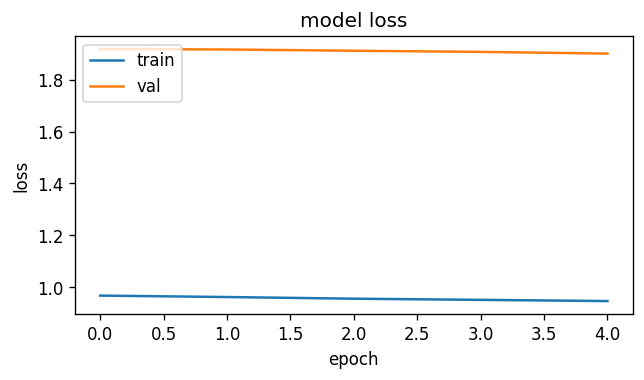

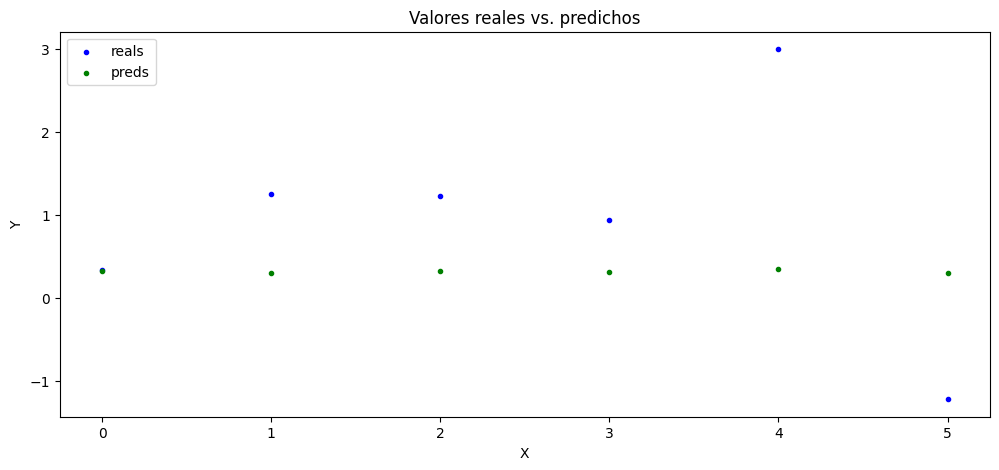

In [ ]:
mejor_modelo, _, _, _ = proceso_completo( \
        modelo='lstm', past_history=20, future_target=4, step=2,
        num_capas=1, num_hidden=20, showPlots=True)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
val_data = SerieTiempoMultivariadaDataset(dataset, dataset[:, 0], TRAIN_SPLIT, None,
                                               past_history, future_target,
                                               STEP, single_step=True)

reals = torch.squeeze(val_data.labels)
preds = pronostico(mejor_modelo, val_data, BATCH_SIZE).cpu().numpy()

naive_reals=val_data.labels[future_target:]
naive_preds=val_data.labels[:-future_target]

print(f"MAPE modelo:   {mean_absolute_percentage_error(reals, preds)}")
print(f"MAPE baseline: {mean_absolute_percentage_error(naive_reals, naive_preds)}")

print(f"RMSE modelo:   {math.sqrt(mean_squared_error(reals, preds))}")
print(f"RMSE baseline: {math.sqrt(mean_squared_error(naive_reals, naive_preds))}")

print(f"R2 modelo:   {r2_score(reals, preds)}")
print(f"R2 baseline: {r2_score(naive_reals, naive_preds)}")

MAPE modelo:   0.7184300422668457
MAPE baseline: 1.4606395959854126
RMSE modelo:   1.3788092473737295
RMSE baseline: 2.57135582245749
R2 modelo:   -0.20936478539401593
R2 baseline: -0.4900841753012708


In [ ]:
preds

array([0.32177138, 0.30605447, 0.32824415, 0.31222028, 0.34624487,
       0.29518136], dtype=float32)

### MODELO DE ENSAMBLE

In [ ]:
# se escogen las variables para el modelo
['ropamujer', 'correo', 'páginas', 'teléfono', 'impresa', 'servicio',
       'idmercado', 'nomina']

In [ ]:
df.

,ropamujer,correo,páginas,teléfono,impresa,servicio,idmercado,tamañomer,idloc,edadloc,promo,nomina
1943-12-31,16578.93,7978,73,34,22294.48,20,1,Grande,1,7,3,26780
1944-12-31,43393.55,8029,65,24,27978.66,26,1,Grande,2,1,2,24789
1945-12-31,30908.49,7752,85,20,28949.65,22,1,Grande,3,6,2,25121
1946-12-31,28701.58,8685,74,17,22642.27,21,1,Grande,4,10,1,27648
1947-12-31,29647.57,7847,87,30,27210.61,23,1,Grande,5,5,3,25982
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31,51194.98,10789,102,37,28642.16,45,7,Pequeño,76,22,1,23263
2019-12-31,50884.34,11419,87,41,29108.63,47,7,Pequeño,77,6,1,20910
2020-12-31,47875.82,11419,89,45,24164.44,43,7,Pequeño,78,9,1,21683
2021-12-31,69112.81,13666,91,52,34843.65,54,8,Median,79,12,2,17745


In [ ]:
df.columns

Index(['ropamujer', 'correo', 'páginas', 'teléfono', 'impresa', 'servicio',
       'idmercado', 'tamañomer', 'idloc', 'edadloc', 'promo', 'nomina'],
      dtype='object')

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

df1 = df[['ropamujer', 'correo', 'páginas', 'teléfono', 'impresa', 'servicio', 'idmercado', 'nomina']]

# Agregar columnas para el promedio de las 3 columnas anteriores (sin incluir la fila actual)
for col in ['correo', 'páginas', 'teléfono', 'servicio', 'nomina']:
    df1[f'{col}_promedio'] = df1[col].shift(1).rolling(window=3).mean()

# Eliminar las columnas originales que se utilizaron para el cálculo del promedio
df1 = df1.drop(['correo', 'páginas', 'teléfono', 'servicio', 'nomina'], axis=1)

# Eliminar filas con NaN resultantes del cálculo del promedio
df1 = df1.dropna()

<ipython-input-108-adf8f4ef3ef2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[f'{col}_promedio'] = df1[col].shift(1).rolling(window=3).mean()
<ipython-input-108-adf8f4ef3ef2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[f'{col}_promedio'] = df1[col].shift(1).rolling(window=3).mean()
<ipython-input-108-adf8f4ef3ef2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [ ]:
df.head()

,ropamujer,correo,páginas,teléfono,impresa,servicio,idmercado,tamañomer,idloc,edadloc,promo,nomina
1943-12-31,16578.93,7978,73,34,22294.48,20,1,Grande,1,7,3,26780
1944-12-31,43393.55,8029,65,24,27978.66,26,1,Grande,2,1,2,24789
1945-12-31,30908.49,7752,85,20,28949.65,22,1,Grande,3,6,2,25121
1946-12-31,28701.58,8685,74,17,22642.27,21,1,Grande,4,10,1,27648
1947-12-31,29647.57,7847,87,30,27210.61,23,1,Grande,5,5,3,25982


In [ ]:
df1.head()

,ropamujer,impresa,idmercado,correo_promedio,páginas_promedio,teléfono_promedio,servicio_promedio,nomina_promedio
1946-12-31,28701.58,22642.27,1,7919.666667,74.333333,26.000000,22.666667,25563.333333
1947-12-31,29647.57,27210.61,1,8155.333333,74.666667,20.333333,23.000000,25852.666667
1948-12-31,31141.51,26632.96,1,8094.666667,82.000000,22.333333,22.000000,26250.333333
1949-12-31,31177.31,30374.97,1,8137.666667,80.000000,25.000000,22.000000,26222.000000
1950-12-31,30672.37,26794.79,1,7949.666667,79.333333,28.333333,21.666667,25699.000000


In [ ]:
df1.columns

Index(['ropamujer', 'impresa', 'idmercado', 'correo_promedio',
       'páginas_promedio', 'teléfono_promedio', 'servicio_promedio',
       'nomina_promedio'],
      dtype='object')

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

In [ ]:
# Dividir datos en conjuntos de entrenamiento y prueba
train_size = int(len(df1) * 0.8)
train_data, test_data = df1.iloc[:train_size], df1.iloc[train_size:]

# Seleccionar características y variable objetivo
features = ['impresa', 'idmercado', 'correo_promedio',
       'páginas_promedio', 'teléfono_promedio', 'servicio_promedio',
       'nomina_promedio']
target = 'ropamujer'

# Crear varios modelos de ensamble
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42)
}

best_model_name = None
best_rmse = float('inf')

# Dividir los datos de series temporales usando TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for model_name, model in models.items():
    avg_rmse = 0

    for train_index, val_index in tscv.split(train_data):
        X_train, X_val = train_data[features].iloc[train_index], train_data[features].iloc[val_index]
        y_train, y_val = train_data[target].iloc[train_index], train_data[target].iloc[val_index]

        # Entrenar el modelo
        model.fit(X_train, y_train)

        # Realizar predicciones en el conjunto de validación
        predictions = model.predict(X_val)

        # Calcular RMSE
        rmse = mean_squared_error(y_val, predictions, squared=False)
        avg_rmse += rmse

    avg_rmse /= tscv.n_splits

    print(f'{model_name} - Average RMSE: {avg_rmse}')

    # Actualizar el mejor modelo si se encuentra un menor RMSE
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_model_name = model_name

print(f'El mejor modelo es {best_model_name} con RMSE: {best_rmse}')

RandomForest - Average RMSE: 9696.407410420083
GradientBoosting - Average RMSE: 9893.275136964134
AdaBoost - Average RMSE: 10021.101836182006
El mejor modelo es RandomForest con RMSE: 9696.407410420083


In [ ]:
import shap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Separar el conjunto de datos en variables independientes (X) y variable dependiente (y)
X = data.drop('ropamujer', axis=1)
y = data['ropamujer']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un modelo de regresión (puedes cambiar esto según tu necesidad)
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Crear un explainer de Shapley
explainer = shap.TreeExplainer(model)

# Calcular los Shapley values para un conjunto de datos de prueba
shap_values = explainer.shap_values(X_test)

# Mostrar los Shapley values
shap.summary_plot(shap_values, X_test)